In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette(soft=True)
dpi = putils.set_plot_params()


# Dataset info

In [7]:
#### Set options
responsive_test='ROC'
responsive_thr=0.05

analysis_type='split_pupil'
n_iterations=100
overlap_thr=None
n_processes=1
experiment='blobs'
C_value=None

options=['-E', experiment, '-R', responsive_test, '-n', n_processes, '-N', n_iterations, 
         '-o', overlap_thr, '-C', C_value, '-X', analysis_type]


In [8]:
#### Extract options
opts = dc.extract_options(options)
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = opts.rootdir
create_new = opts.create_new
verbose=opts.verbose

# Pick dataset ------------------------------------ 
traceid = opts.traceid #'traces001'
response_type = opts.response_type #'dff'
responsive_test = opts.responsive_test #'nstds' # 'nstds' #'ROC' #None
if responsive_test=='None':
    responsive_test=None
responsive_thr = float(opts.responsive_thr) if responsive_test is not None else 0.05 #10

# Classifier info ---------------------------------
experiment = opts.experiment #'blobs'
class_a=int(opts.class_a) #0
class_b=int(opts.class_b) #106
n_iterations=int(opts.n_iterations) #100 
n_processes=int(opts.n_processes) #2
trial_epoch = 'plushalf'

analysis_type=opts.analysis_type

# CV ----------------------------------------------
test_split=0.2
cv_nfolds=5
C_value=opts.C_value
# do_cv = opts.do_cv
#C_value = opts.C_value
do_cv = C_value is None

print("Do CV -%s- (C=%s)" % (str(do_cv), str(C_value)))

# Dataset filtering --------------------------------
filter_fovs = True
remove_too_few = True
min_ncells = 10 if remove_too_few else 0
overlap_thr = None if opts.overlap_thr in ['None', None] else float(opts.overlap_thr)
has_rfs = overlap_thr is not None

stim_filterby = None # 'first'
has_gratings = experiment!='blobs'

match_distns = opts.match_distns
if analysis_type=='single_cells':
    match_distns = False
match_str = 'matchdistns_' if match_distns else ''

# Pupil -------------------------------------------
pupil_feature='pupil_area'
pupil_alignment='trial'
pupil_epoch='pre'
pupil_snapshot=391800
redo_pupil=False
pupil_framerate=20.
# -------------------------------------------------

# Alignment 
iti_pre=1.
iti_post=1.
stim_dur=1.

# RF stuff 
rf_filter_by=None
reliable_only = True
rf_fit_thr = 0.05

Do CV -True- (C=None)


In [9]:
train_str = '%s_iter-%i' % (analysis_type, n_iterations)
print(train_str)

# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()

split_pupil_iter-100


# Output dir

In [10]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

dst_dir = os.path.join(aggregate_dir, 'decoding', analysis_type)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    print(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil


# Get metadata for experiment type

In [11]:
#### Get metadata for experiment type
print("Filtering <%s> by: %s" % (experiment, str(stim_filterby)))
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
dsets, keys_by_area = aggr.experiment_datakeys(experiment=experiment, 
                            experiment_only=False,stim_filterby=stim_filterby,
                            has_gratings=has_gratings, has_rfs=has_rfs, )
stim_datakeys = dsets['datakey'].unique()


Filtering <blobs> by: None
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets


# Get source (input) data

In [12]:
responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05

print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")


curr_visual_area=None #'V1'
curr_datakey = None# '20190617_JC097_fov1'

#### Load neural responses
# analysis_type='split_pupil'

trial_epoch='plushalf'
response_type='dff'

# match_distns=False
# overlap_thr=0.0
# has_rfs = overlap_thr is not None
stack_neuraldf = analysis_type in ['by_ncells']

#### Check for equal trial counts
visual_areas=['V1', 'Lm', 'Li', 'Ll']
_, all_cells, MEANS, SDF = aggr.get_source_data(experiment,
                        equalize_now=True, zscore_now=True,
                        response_type=response_type, responsive_test=responsive_test,
                        responsive_thr=responsive_thr, trial_epoch=trial_epoch, #use_all=False,
                        visual_area=curr_visual_area,
                        datakey=curr_datakey,
                        check_configs=True, return_configs=True, return_missing=False,
                        images_only=analysis_type=='by_ncells')

all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
all_cells.groupby(['visual_area']).count()


............................................
Responsive test: ROC (thr=0.05)
............................................
Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
(skipping 20190314_JC070_fov1)
---equalizing now---
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])
Segmentation: missing 3 dsets


cell   fov  animalid  session  datakey  fovnum  global_ix
visual_area                                                           
Li            585   585       585      585      585     585        585
Ll             39    39        39       39       39      39         39
Lm           1127  1127      1127     1127     1127    1127       1127
V1           1251  1251      1251     1251     1251    1251       1251

In [13]:
overlap_thr=None
has_retino=False
threshold_dff=False
threshold_snr=False

has_rfs = (has_retino is False) and (overlap_thr is not None)
print('retino:', has_retino, 'rfs:', has_rfs)

match_distns = False
stack_neuraldf = analysis_type in ['by_ncells']

remove_too_few=False
min_ncells=5

if analysis_type in ['single_cells', 'by_fov', 'split_pupil']:
    match_distns = False
    
NEURALDATA, CELLS = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                            stack_neuraldf=stack_neuraldf, overlap_thr=overlap_thr, 
                            has_retino=has_retino, threshold_snr=threshold_snr, 
                            remove_too_few=remove_too_few, min_ncells=min_ncells) 
                                
print("------------------------------------")
print("Final cell counts:")
CELLS[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

cell_counts = dict(CELLS.groupby(['visual_area'])['cell'].count())

print("@@@@@@@@ cell counts @@@@@@@@@@@")
print(cell_counts)


('retino:', False, 'rfs:', False)
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Ll' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Ll': 39, u'Lm': 1127, u'Li': 585}
------------------------------------
------------------------------------
Final cell counts:
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Ll': 39, u'Lm': 1127, u'Li': 585}


In [14]:
match_str = 'matchdistns_' if match_distns else ''
if threshold_dff:
    overlap_str = 'threshdff'
else:
    if has_retino:
        overlap_str = 'retino'
    else:
        overlap_str = 'noRF' if overlap_thr is None else 'overlap%.1f' % overlap_thr


In [15]:
results_id = dc.create_results_id(prefix='split_pupil', visual_area=curr_visual_area, 
                        response_type=response_type, responsive_test=responsive_test,
                        trial_epoch=trial_epoch, C_value=C_value, 
                        has_retino=has_retino,overlap_thr=overlap_thr, 
                        threshold_dff=threshold_dff)
print(results_id)

split_pupil_None__dff-ROC_noRF__plushalf__tuneC


In [12]:
# NDATA = aggr.neuraldf_dict_to_dataframe(NEURALDATA, response_type='response')
    
# counts = NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area', 'datakey']).count().reset_index()
# counts.head()

#### Combine into stacked df

In [14]:
# fig, ax = pl.subplots(figsize=(4,3))
# # sns.barplot(x='visual_area', y='cell', data=counts, ax=ax,
# #            hue='datakey', palette='colorblind')
# # ax.legend_.remove()
# sns.barplot(x='visual_area', y='cell', data=counts, ax=ax,
#            facecolor='w', edgecolor=('k', 'k', 'k'), order=visual_areas)
# sns.stripplot(x='visual_area', y='cell', data=counts, ax=ax,
#             order=visual_areas, color='k', s=10)
# ax.set_title("N cells, by FOV (test=%s, thr=%.2f)" \
#              % (responsive_test, responsive_thr), loc='left')


# Pupil

In [16]:
from pipeline.python.eyetracker import dlc_utils as dlcutils

In [17]:
def get_pupil_trial_counts(pupildata):
    '''
    expects pupildata to be a dict (key=datakey, value=pupil data df)
    '''
    c_=[]
    for datakey, pdata in pupildata.items():
        ntrials_t = pdata.shape[0]
        ntrials_p = pdata.dropna().shape[0]
        c_.append(pd.Series({'datakey': datakey, 'ntrials_total': ntrials_t, 'ntrials_pass': ntrials_p}))
    pupil_counts = pd.concat(c_, axis=1).T
    pupil_counts['ntrials_missing'] = pupil_counts['ntrials_total'] - pupil_counts['ntrials_pass']
    pupil_counts.index = pupil_counts['datakey']
    pupil_counts = pupil_counts.drop(['datakey'], axis=1)
    
    return pupil_counts


In [18]:
def count_pupil_train_trials(ndata, pdata, sdf, class_name='morphlevel', class_a=0, class_b=106):
    '''
    Return subset of trials for training set or decoding subset.
    ndata: df (neural df for 1 dset)
    pdata: df (pupil df for 1 dset)
    '''
    #noncell_cols=['visual_area', 'datakey', 'config', 'trial']
    ndata['trial']=ndata.index
    assert pdata.shape[0] == ndata.shape[0], "Incorrect trial #s included"
    assert sorted(pdata['trial'].unique()) == sorted(ndata['trial'].unique()), "Bad trial naming"

    # Get train configs
    #class_a=0; class_b=106;
    train_configs = sdf[sdf[class_name].isin([class_a, class_b])].index.tolist()
    train_trials = sorted(ndata[ndata['config'].isin(train_configs)]['trial'].unique())

    sub_pdata = pdata[pdata['trial'].isin(train_trials)] #.dropna()
    sub_ndata = ndata[ndata['trial'].isin(train_trials)] #.dropna()
    
    return sub_ndata, sub_pdata

In [19]:
pupil_feature = 'pupil_area'
pupil_epoch = 'pre'
alignment_type='trial'
pupil_snapshot=391800

redo_pupil=False 
pupil_framerate=20.   
iti_pre=1.
iti_post=1.
stim_dur=1.
n_cuts=3

#if 'pupil' in analysis_type:
pupildata = dlcutils.get_aggregate_pupildfs(experiment=experiment, 
                                        feature_name=pupil_feature, 
                                        alignment_type=alignment_type,
                                        trial_epoch=pupil_epoch,
                                        iti_pre=iti_pre, iti_post=iti_post, stim_dur=stim_dur,
                                        in_rate=pupil_framerate, out_rate=pupil_framerate,
                                        snapshot=pupil_snapshot, create_new=redo_pupil)

>>>> Loaded aggregate pupil dataframes.


In [20]:
# pupil_counts = get_pupil_trial_counts(pupildata)
# pupil_counts.head()

In [21]:
# datakey = '20190510_JC083_fov1'
# pdata0 = pupildata[datakey].copy()
# ndata0 = MEANS[datakey].copy() #NDATA[NDATA['datakey']==datakey].copy()
# ndata, pdata = dlcutils.match_trials_df(ndata0, pdata0, equalize_conditions=False)

# sdf = SDF[datakey].copy()
# ndata['trial']=ndata.index
# assert pdata.shape[0] == ndata.shape[0], "Incorrect trial #s included"
# assert sorted(pdata['trial'].unique()) == sorted(ndata['trial'].unique()), "Bad trial naming"

In [22]:
# sub_ndata, sub_pdata = count_pupil_train_trials(ndata, pdata, sdf)
# sub_pdata.shape, sub_pdata.dropna().shape

# # Get train configs
# class_a=0; class_b=106; class_name='morphlevel';
# train_configs = sdf[sdf[class_name].isin([class_a, class_b])].index.tolist()
# train_trials = sorted(ndata[ndata['config'].isin(train_configs)]['trial'].unique())
# len(train_trials)

## Aggregate pupil data into df

In [23]:
# class_a=0; class_b=106;
# train_configs = sdf[sdf['morphlevel'].isin([class_a, class_b])].index.tolist()
pupildata_c={}
ndata_c=[]
plist=[]
for datakey, pdata in pupildata.items():
    ndata = MEANS[datakey].copy()
    ndata, pdata = dlcutils.match_trials_df(ndata, pdata, equalize_conditions=False)    
    sdf = SDF[datakey].copy()
    try:
        sub_ndata, sub_pdata = count_pupil_train_trials(ndata, pdata, sdf)
    except AssertionError as e:
        print(datakey, e)
    pupildata_c[datakey] = sub_pdata
    ndata_c.append(sub_ndata)
    
    pdata['config'] = [ndata[ndata['trial']==t]['config'].unique()[0] for t in pdata['trial']]
    pdata['datakey'] = datakey
    pdata['size'] = [sdf['size'][c] for c in pdata['config']]
    pdata['morphlevel'] = [sdf['morphlevel'][c] for c in pdata['config']]
    plist.append(pdata)
ndata_c = pd.concat(ndata_c, axis=0)

pupildf = pd.concat(plist, axis=0).reset_index(drop=True)

In [24]:
pcounts = get_pupil_trial_counts(pupildata_c)
pcounts['fraction_missing'] = pcounts['ntrials_missing'].divide(pcounts['ntrials_total'].astype(float))

pcounts.head()

ntrials_pass ntrials_total ntrials_missing  \
datakey                                                          
20190512_JC083_fov1          281           310              29   
20190420_JC076_fov1          248           300              52   
20190603_JC080_fov1          297           300               3   
20190506_JC080_fov1          199           290              91   
20190510_JC083_fov1          159           350             191   

                    fraction_missing  
datakey                               
20190512_JC083_fov1        0.0935484  
20190420_JC076_fov1         0.173333  
20190603_JC080_fov1             0.01  
20190506_JC080_fov1         0.313793  
20190510_JC083_fov1         0.545714

In [25]:
pupildf.head()

trial  frame  pupil_area  frame_int  frame_ix  pupil_fraction     config  \
0    1.0    9.5  593.718311        9.5       9.5        0.582607  config019   
1    2.0    9.5  412.658117        9.5       9.5        0.404935  config002   
2    3.0    9.5  409.877847        9.5       9.5        0.402207  config011   
3    4.0    9.5  451.443446        9.5       9.5        0.442995  config020   
4    5.0    9.5  348.668212        9.5       9.5        0.342143  config001   

               datakey  size  morphlevel  
0  20190512_JC083_fov1  40.0          27  
1  20190512_JC083_fov1  20.0          -1  
2  20190512_JC083_fov1  10.0          14  
3  20190512_JC083_fov1  50.0          27  
4  20190512_JC083_fov1  10.0          -1

## Test classifier w/ example FOV

In [26]:
datakey = '20190612_JC099_fov1'
session, animalid, fovn = datakey.split('_')
fovnum = int(fovn[3:])
visual_area='Li'
datakey in pupildata.keys()

# ------ STIMULUS INFO -----------------------------------------
obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()


In [37]:
neuraldf = aggr.get_neuraldf_for_cells_in_area(cells, MEANS, datakey=datakey, visual_area=visual_area)
n_cells = int(neuraldf.shape[1]-1)
curr_rois = cells[(cells['datakey']==datakey) & (cells['visual_area']==visual_area)]['cell'].values
assert n_cells==len(curr_rois)

In [38]:
print("... [%s] %s, n=%i cells" % (visual_area, datakey, n_cells))

... [Li] 20190612_JC099_fov1, n=51 cells


In [39]:
pupildf = pupildata[datakey].copy()
pupildf.shape

(1500, 5)

In [40]:
# match neural trials, pupil trials
neuraldf, pupildf = dlcutils.match_trials_df(neuraldf, pupildf, equalize_conditions=True)

# zscore
neuraldf = aggr.zscore_neuraldf(neuraldf)

In [41]:
pupil_low, pupil_high = dlcutils.split_pupil_range(pupildf, feature_name=pupil_feature, n_cuts=n_cuts)
print(pupil_low.shape, pupil_high.shape)


((500, 5), (500, 5))


In [42]:
low_trial_ixs = pupil_low['trial'].unique()
high_trial_ixs = pupil_high['trial'].unique()
all_trial_ixs = pupildf['trial'].unique()


In [43]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [44]:

# Decoding -----------------------------------------------------
arousal_conds = ['all', 'low', 'high']
arousal_trial_ixs = [all_trial_ixs, low_trial_ixs, high_trial_ixs]
iter_list=[]
for arousal_cond, curr_trial_ixs in zip(arousal_conds, arousal_trial_ixs):
    # Get neuraldf for current trials
    curr_data = neuraldf.loc[curr_trial_ixs].copy()
    # Fit.
    a_list = decutils.fit_svm_mp(curr_data, sdf, C_value=C_value, 
                            n_iterations=n_iterations, 
                            n_processes=n_processes, verbose=verbose,
                            class_a=class_a, class_b=class_b) 
    print("%i items in mp list" % len(a_list))
    # Aggregate 
    arousal_df = pd.concat(a_list, axis=0)
    metainfo = {'visual_area': visual_area, 'datakey': datakey,
                'arousal': arousal_cond, 'n_cells': n_cells}
    arousal_df = putils.add_meta_to_df(arousal_df, metainfo)
    iter_list.append(arousal_df)

print("%i items in split-pupil list" % len(iter_list))
# DATA - get mean across items
iter_results = pd.concat(iter_list, axis=0)

1 items in mp list
1 items in mp list
1 items in mp list
3 items in split-pupil list


In [46]:
iter_results.shape

(300, 14)

In [47]:
iter_results.groupby(['arousal']).mean()

C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
arousal                                                               
all      3.30472  0.106836    0.008496     0.001509        0.012258   
high     0.48385  0.000945    0.017633    -0.000679        0.025440   
low      0.18478  0.000661    0.009628    -0.006559        0.013891   

         heldout_test_score  n_cells  n_trials  score_time  test_score  \
arousal                                                                  
all                0.514833       51       300    0.000667    0.548165   
high               0.472727       51       110    0.000308    0.533456   
low                0.505556       51        90    0.000287    0.543497   

         train_score  
arousal               
all         0.688407  
high        0.752631  
low         0.679035

# Test loading for example FOV

In [26]:
reload(dc)

<module 'pipeline.python.classifications.decode_by_ncells' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_by_ncells.py'>

In [29]:
overlap_thr=None
C_value=None
trial_epoch='plushalf'

results_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, 
                                response_type=response_type, responsive_test=responsive_test, 
                                overlap_thr=overlap_thr, trial_epoch=trial_epoch, test_type=None)
results_id

'split_pupil_varea__dff-ROC_noRF__plushalf__tuneC'

In [30]:
_, response_id, tepoch, C_str = results_id.split('__')
# C_str = 'tuneC' if C_value is None else 'C-%.2f' % float(C_value)
result_str = '%s__%s__%s__%s' % (analysis_type, response_id, tepoch, C_str)
result_str

'split_pupil__dff-ROC_noRF__plushalf__tuneC'

In [31]:
# datakey = '20190522_JC084_fov1'
# visual_area = 'V1'

datakey = '20190622_JC085_fov1'
visual_area = 'V1'

session, animalid, fovn = datakey.split('_')
fovnum = int(fovn[3:])
fov = 'FOV%i_zoom2p0x' % fovnum
results_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, visual_area=visual_area,
                                response_type=response_type, responsive_test=responsive_test, 
                                overlap_thr=overlap_thr, trial_epoch=trial_epoch)

res = dc.load_decode_within_fov(animalid, session, fov, results_id=results_id, traceid=traceid)
res.groupby(['condition', 'arousal']).mean()

C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
condition arousal                                                               
data      all      0.02458  0.010805    0.083209     0.109045        0.120045   
          high     0.04852  0.000932    0.133231     0.130177        0.192212   
          low      0.03916  0.001227    0.030768     0.002482        0.044389   
shuffled  all      0.16174  0.013093    0.006423    -0.003152        0.009266   
          high     0.01738  0.001072    0.017072    -0.005277        0.024630   
          low      0.01405  0.001080    0.013359    -0.004693        0.019273   

                   heldout_test_score  score_time  test_score  train_score  \
condition arousal                                                            
data      all                0.689333    0.002835    0.698792     0.896635   
          high               0.683333    0.000270    0.675889     0.989405   
          low                0.555385    0.000415    0.597091     0.844729   
shuffled  all                0.502000    0.002381    0.520250     0.817292   
          high               0.496667    0.000381    0.557000     0.698833   
          low                0.521538    0.000394    0.579354     0.719437   

                   n_cells  n_trials  iteration  
condition arousal                                
data      all        196.0     300.0       49.5  
          high       196.0      58.0       49.5  
          low        196.0      64.0       49.5  
shuffled  all        196.0     300.0       49.5  
          high       196.0      58.0       49.5  
          low        196.0      64.0       49.5

In [32]:
traceid_dir = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_blobs*',
                                     'traces', '%s*' % traceid))[0]
curr_dst_dir = os.path.join(traceid_dir, 'decoding')    
results_outfile = os.path.join(curr_dst_dir, '%s.pkl' % results_id)  


os.path.exists(results_outfile)


True

# Unique dsets

In [26]:
filter_by='most_fits'
blob_dsets = aggr.get_blob_datasets(filter_by=filter_by, as_dict=False, response_type=response_type,
                                    responsive_test=responsive_test, responsive_thr=responsive_thr)

all_dkeys = sdata[(sdata['experiment']==experiment)]['datakey'].unique()
unique_dkeys = blob_dsets['datakey'].unique()

n_drop = len(all_dkeys) - len(unique_dkeys)
print("Dropping %i dkeys (%i of %i dkeys unique)" % (n_drop, len(unique_dkeys), len(all_dkeys)))

Segmentation: missing 9 dsets
Segmentation: missing 3 dsets
[AL] Animalid does not exist: JC099 
[Ll] Animalid does not exist: JC067 
[Ll] Animalid does not exist: JC099 
[POR] Animalid does not exist: JC076 
[V1] Animalid does not exist: JC078 
Dropping 12 dkeys (30 of 42 dkeys unique)


# Aggregate decoding results

In [27]:
reload(dc)

<module 'pipeline.python.classifications.decode_by_ncells' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_by_ncells.pyc'>

In [28]:
C_value=None
match_distns=False
overlap_thr=None
has_retino=False
threshold_dff= False

responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05

print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")

trial_epoch='plushalf' #'stimulus'
analysis_type='split_pupil'
# -------------------------------------------------------------------------------------
data_id = dc.create_results_id_aggr(prefix=analysis_type, C_value=C_value,
                        response_type=response_type, responsive_test=responsive_test,
                        overlap_thr=overlap_thr, trial_epoch=trial_epoch, 
                        has_retino=has_retino, threshold_dff=threshold_dff)

df, missing = dc.do_decode_within_fov(analysis_type=analysis_type, experiment=experiment, verbose=False,
                    responsive_test=responsive_test, responsive_thr=responsive_thr,
                    response_type=response_type, traceid=traceid, C_value=C_value, 
                    trial_epoch=trial_epoch, match_distns=match_distns,
                    overlap_thr=overlap_thr, has_retino=has_retino, 
                    threshold_dff=threshold_dff, return_missing=True)

df = aggr.split_datakey(df)

............................................
Responsive test: ROC (thr=0.05)
............................................
AGGREGATE: split_pupil___dff-ROC_noRF__plushalf__tuneC
AGGREGATE: split_pupil___dff-ROC_noRF__plushalf__tuneC
Segmentation: missing 9 dsets
No results for 16 dsets:
SAVING.....
-- results: /n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/split_pupil___dff-ROC_noRF__plushalf__tuneC.pkl
-- params: /n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/split_pupil___dff-ROC_noRF__plushalf__tuneC_params.json
DONE!


In [29]:
missing

[(u'Li', '20190314_JC070_fov1'),
 (u'Li', '20190315_JC070_fov1'),
 (u'Li', '20190316_JC070_fov1'),
 (u'Li', '20190319_JC067_fov1'),
 (u'Li', '20190320_JC067_fov1'),
 (u'Li', '20190321_JC070_fov1'),
 (u'Li', '20190322_JC073_fov1'),
 (u'Li', '20190327_JC073_fov1'),
 (u'Li', '20190422_JC076_fov1'),
 (u'Ll', '20190319_JC067_fov1'),
 (u'Ll', '20190320_JC067_fov1'),
 (u'Ll', '20190612_JC099_fov1'),
 (u'Lm', '20190306_JC061_fov3'),
 (u'Lm', '20190322_JC073_fov1'),
 (u'Lm', '20190327_JC073_fov1'),
 (u'Lm', '20190422_JC076_fov1')]

In [30]:
#### Average over iterations
visual_areas = ['V1', 'Lm', 'Li']
meandf = df.groupby(['visual_area', 'datakey', 'condition', 'arousal']).mean().reset_index()
meandf = meandf[meandf.visual_area.isin(visual_areas)]

# Addd pupil count data
meandf['fraction_missing'] = [pcounts.loc[dk]['fraction_missing'] for dk in meandf['datakey']]
meandf['n_missing'] = [pcounts.loc[dk]['ntrials_missing'] for dk in meandf['datakey']]
meandf['n_pass'] = [pcounts.loc[dk]['ntrials_pass'] for dk in meandf['datakey']]
meandf['feature_sample_ratio'] = meandf['n_cells']/meandf['n_pass']

# Calcualte change over shuffled
meandf['fold_over_shuffle'] = 0.0
for (v, dk, a), g in meandf.groupby(['visual_area', 'datakey', 'arousal']):
    val = float(g[g.condition=='data']['heldout_test_score'])
    shuf = float(g[g.condition=='shuffled']['heldout_test_score'])
    meandf['fold_over_shuffle'][g.index] = (val-shuf)/shuf
    
meandf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

datakey
visual_area         
Li                 9
Lm                13
V1                16

# Output dir

In [31]:
curr_dst_dir = os.path.join(dst_dir, responsive_test)
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/ROC


In [34]:
all_df.columns

Index([u'C', u'fit_time', u'heldout_MI', u'heldout_aMI', u'heldout_log2MI',
       u'heldout_test_score', u'randi', u'score_time', u'test_score',
       u'train_score', u'condition', u'n_cells', u'n_trials', u'iteration',
       u'arousal', u'visual_area', u'datakey', u'animalid', u'fov',
       u'session'],
      dtype='object')

# Exclude garbage results

In [42]:
reload(decutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

In [43]:
metric = 'heldout_test_score'
all_df = df[df.arousal=='all'].copy()
percentiles = decutils.get_percentile_shuffled(all_df, metric=metric)
percentiles.shape

(38, 14)

In [31]:
# d_ = all_df[(all_df.visual_area=='Li') & (all_df.datakey=='20191018_JC113_fov1')].copy()
# mean_score = d_[d_['condition']=='data'][metric].mean()
# percentile = np.mean(mean_score < d_[d_['condition']=='shuffled'][metric])
# print(mean_score, percentile)

# fig, ax = pl.subplots(figsize=(4,3))
# sns.distplot(d_[d_.condition=='data'][metric], color='m', ax=ax)
# sns.distplot(d_[d_.condition=='shuffled'][metric], color='k', ax=ax)
# ax.axvline(x=0.5)

In [64]:
pass_thr=0.05 
pass_acc = percentiles[percentiles.percentile < pass_thr].copy()
print(percentiles.groupby(['visual_area'])['datakey'].count().reset_index())

print("Percentile %.2f of shuffled:" % pass_thr)
print(pass_acc.groupby(['visual_area'])['datakey'].count().reset_index()) ##[['visual_area', 'datakey', 'percentile']])

#### and # of pupil trials missing is below some threshold
min_ntrials=500 #1000
pass_acc = pass_acc[pass_acc.n_trials>=min_ntrials]

#### Only include dsets where overall accuracy > shuffled
# pass_acc = pd.concat([g for (visual_area, datakey), g \
#             in meandf[meandf['arousal']=='all'].groupby(['visual_area', 'datakey']) \
#                       if round(g['fold_over_shuffle'].unique(), 1)>0.])

passdf0 = pd.concat([meandf[(meandf.visual_area==v) & (meandf.datakey==dk)] \
                       for (v, dk), g in pass_acc.groupby(['visual_area', 'datakey'])])

#### and # of pupil trials missing is below some threshold
min_frac = .3
passdf = passdf0[(passdf0['fraction_missing']<min_frac)]

arousaldf = passdf[passdf['arousal'].isin(['high', 'low'])].copy()

print("Missing a min frac %.2f due to pupil:" % pass_thr)
print(passdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

  visual_area  datakey
0          Li        9
1          Lm       13
2          V1       16
Percentile 0.05 of shuffled:
  visual_area  datakey
0          Li        8
1          Lm        9
2          V1       11
Missing a min frac 0.05 due to pupil:
             datakey
visual_area         
Li                 5
Lm                 8
V1                 7


<IPython.core.display.Javascript object>


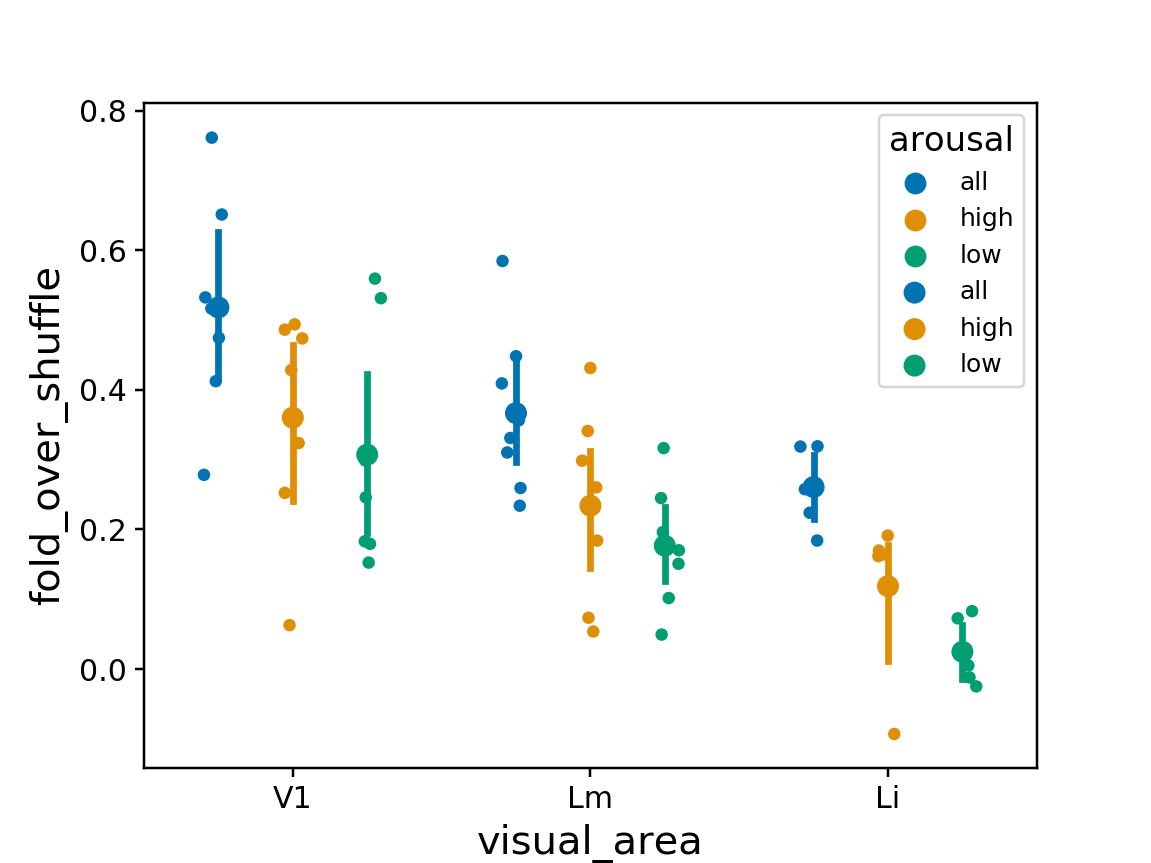

In [65]:
plotdf = passdf[(passdf.condition=='data') & (passdf.n_cells>=0)].copy()

fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='fold_over_shuffle', data=plotdf, ax=ax,
             hue='arousal', dodge=True, order=visual_areas, palette='colorblind')
sns.pointplot(x='visual_area', y='fold_over_shuffle', data=plotdf, ax=ax,
             hue='arousal', dodge=.5, order=visual_areas, palette='colorblind', join=False)


# Drop repeats

In [66]:
metric = 'heldout_test_score'

# Drop repeat FOVs
all_curr_dsets = pd.concat([CELLS[(CELLS.visual_area==v) & (CELLS.datakey==dk)] \
           for (v, dk), g in passdf.groupby(['visual_area', 'datakey'])])\
            .groupby(['visual_area', 'datakey']).count().reset_index()
all_curr_dsets = putils.split_datakey(all_curr_dsets)
curr_dsets = aggr.select_best_fovs(all_curr_dsets)

excl_dsets = ['20190507_JC083_fov1'] #, '20190501_JC076_fov1'] #, '20190617_JC099_fov1'] #'20191018_JC113_fov1']

passdf_drop = pd.concat([passdf[(passdf.visual_area==v) & (passdf.datakey==dk) & ~(passdf.datakey.isin(excl_dsets))] \
                         for (v, dk), g in curr_dsets.groupby(['visual_area', 'datakey'])])
arousaldf_drop = passdf_drop[passdf_drop.arousal.isin(['high', 'low'])].copy()



[V1] Animalid does not exist: JC078 


In [67]:
print(passdf_drop[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
#print(xdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

             datakey
visual_area         
Li                 5
Lm                 5
V1                 4


In [68]:
drop_repeats = True
dset_str = '_aboveshuffle_drop_repeats'
xdf = arousaldf_drop.copy() if drop_repeats else arousaldf.copy()

# passdf[['visual_area','datakey', 'n_cells', 'arousal', 'n_trials', 'fraction_missing']].drop_duplicates()

<IPython.core.display.Javascript object>


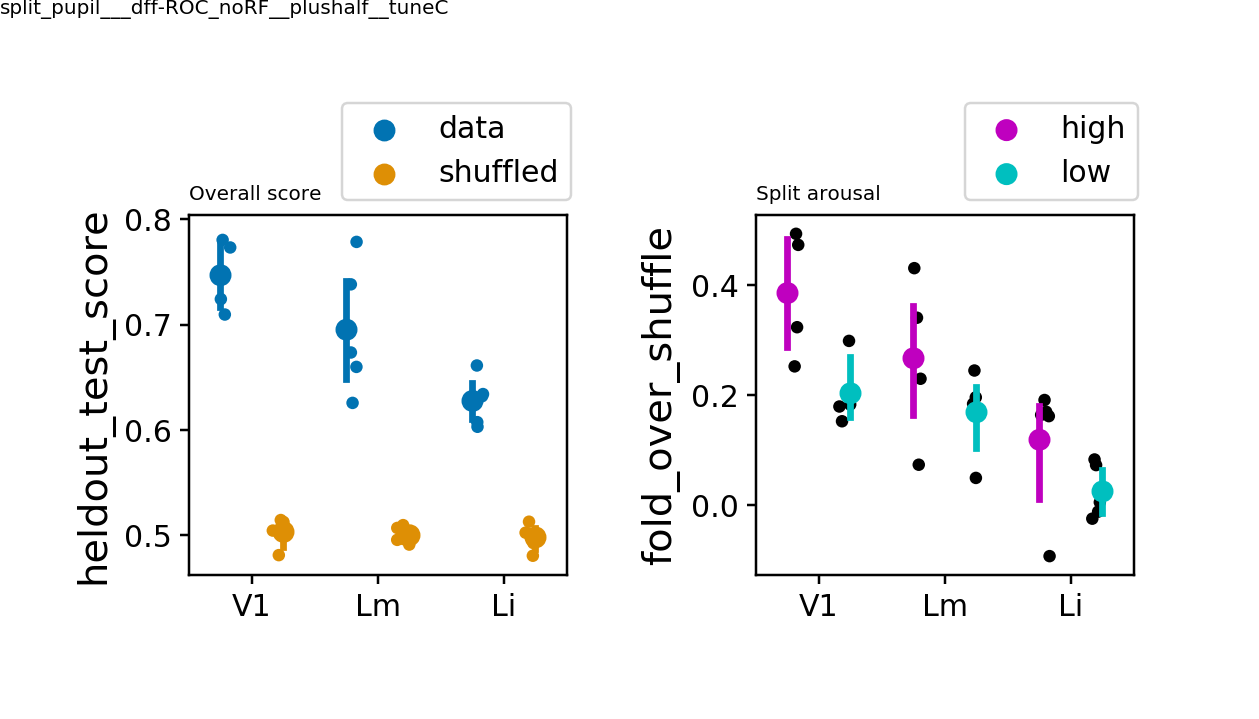

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/ROC', 'compare_shuffle_fold_over_shuffle___aboveshuffle_drop_repeats__split_pupil___dff-ROC_noRF__plushalf__tuneC')


In [69]:
metric = 'fold_over_shuffle'
fig, axn = pl.subplots(1,2, figsize=(7,4), sharey=False, sharex=True)

ax=axn[0]
ax.set_title('Overall score', loc='left', fontsize=8)
sns.stripplot(x='visual_area', y='heldout_test_score', data=passdf_drop[passdf_drop['arousal']=='all'], ax=ax, 
              hue='condition', dodge=True, palette='colorblind', order=visual_areas)  

sns.pointplot(x='visual_area', y='heldout_test_score', data=passdf_drop[passdf_drop['arousal']=='all'], ax=ax, 
              hue='condition', dodge=0.5, palette='colorblind', join=False, order=visual_areas)  
aggr.crop_legend_labels(ax, n_hues=2, loc='lower right', bbox_to_anchor=(1,1))
ax.set_xlabel('')

ax=axn[1]
ax.set_title('Split arousal', loc='left', fontsize=8)
sns.pointplot(x='visual_area', y=metric, data=xdf[xdf['condition']=='data'], ax=ax, 
              hue='arousal', dodge=0.5, palette=('m', 'c'), order=visual_areas, join=False, zorder=-1)
sns.stripplot(x='visual_area', y=metric, data=xdf[xdf['condition']=='data'], ax=ax, 
              hue='arousal', dodge=True, order=visual_areas, palette=('k', 'k'), marker='o', zorder=0)
aggr.crop_legend_labels(ax, n_hues=2, loc='lower right', bbox_to_anchor=(1,1))
ax.set_xlabel('')

pl.subplots_adjust(bottom=0.2, left=0.15, wspace=0.5, top=0.7)
putils.label_figure(fig, data_id)

figname = 'compare_shuffle_%s__%s__%s' % (metric, dset_str, data_id)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

## Compared paired (high/low)

In [70]:
drop_repeats=True

xdf = arousaldf_drop.copy() if drop_repeats else arousaldf.copy()

bothpass = pd.concat([g for (v, k), g in xdf[xdf.condition=='data'].groupby(['visual_area', 'datakey']) \
             if (float(g[g.arousal=='high']['fold_over_shuffle'])>0. )
                 & (float(g[g.arousal=='low']['fold_over_shuffle'])>0.)])

print(xdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print(bothpass[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

             datakey
visual_area         
Li                 5
Lm                 5
V1                 4
             datakey
visual_area         
Li                 2
Lm                 5
V1                 4


<IPython.core.display.Javascript object>


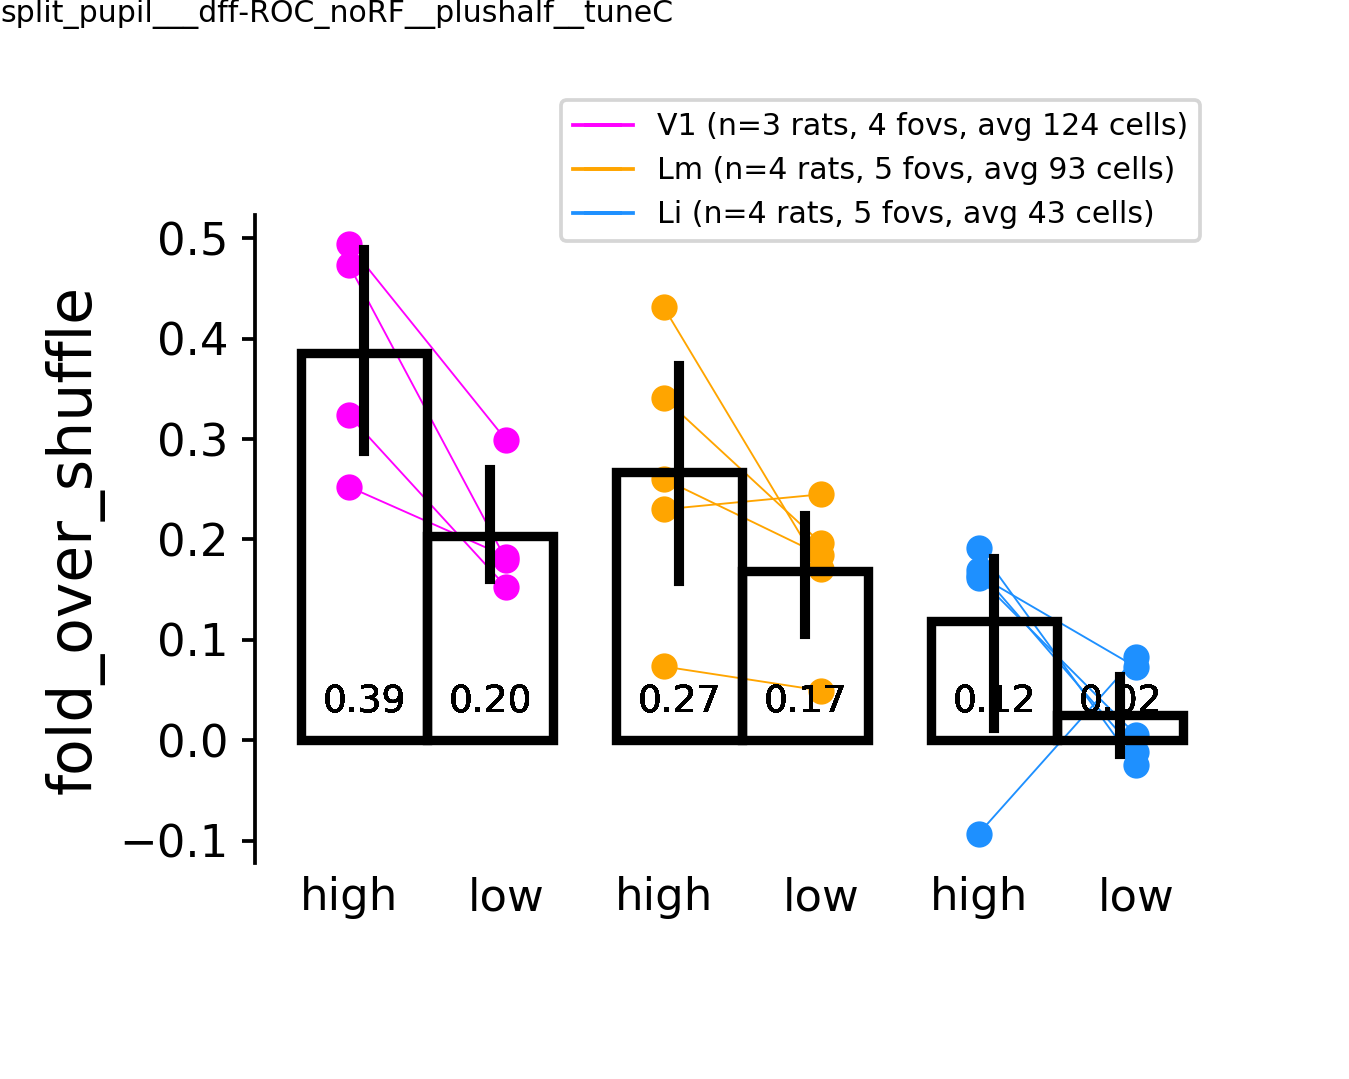

(t-stat:3.96, p=0.03)
(t-stat:2.01, p=0.11)
(t-stat:1.33, p=0.25)


In [71]:
#min_ncells=5
min_ncells=0
min_frac=.5

#xdf = arousaldf_drop.copy() if drop_repeats else arousaldf.copy()

metric='fold_over_shuffle'
#metric='heldout_test_score'
# plotd = bothpass[(bothpass['condition']=='data')
#                  & (bothpass['n_cells']>=min_ncells) & (bothpass['fraction_missing']<=min_frac)]
plotd = xdf[(xdf['condition']=='data')
                 & (xdf['n_cells']>=min_ncells) ] #& (xdf['fraction_missing']<=min_frac)]

c1='high'
c2='low'
compare_var='arousal'

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
ax = aggr.plot_pairwise_by_axis(plotd, curr_metric=metric, c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=True, bbox_to_anchor=(1., 1.2))
ax.set_xlabel('')

pl.subplots_adjust(bottom=0.2, left=0.2, wspace=0.5, top=0.8)
putils.label_figure(fig, data_id)

figname = 'paired_hi-lo_%s__%s__%s' % (metric, dset_str, data_id)
#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [72]:
plotd[plotd.visual_area=='Li'][['datakey', 'arousal', metric, 'n_cells', 'n_trials']]

datakey arousal  fold_over_shuffle  n_cells  n_trials
19  20190609_JC099_fov1    high           0.169794     57.0     475.0
20  20190609_JC099_fov1     low          -0.012000     57.0     474.0
31  20190614_JC091_fov1    high           0.164179     78.0     491.0
32  20190614_JC091_fov1     low           0.072727     78.0     491.0
37  20190617_JC099_fov1    high          -0.092990      7.0     316.0
38  20190617_JC099_fov1     low           0.082960      7.0     316.0
43  20191018_JC113_fov1    high           0.161833     47.0     783.0
44  20191018_JC113_fov1     low           0.005070     47.0     782.0
49  20191111_JC120_fov1    high           0.191207     30.0     497.0
50  20191111_JC120_fov1     low          -0.024809     30.0     497.0

In [73]:
plotd['relative_fold'] = 0
for (v, d), g in plotd.groupby(['visual_area', 'datakey']):
    hi = float(g[g.arousal=='high']['fold_over_shuffle'])
    lo = float(g[g.arousal=='low']['fold_over_shuffle'])
    plotd['relative_fold'][g.index] = (hi-lo)/lo

<IPython.core.display.Javascript object>


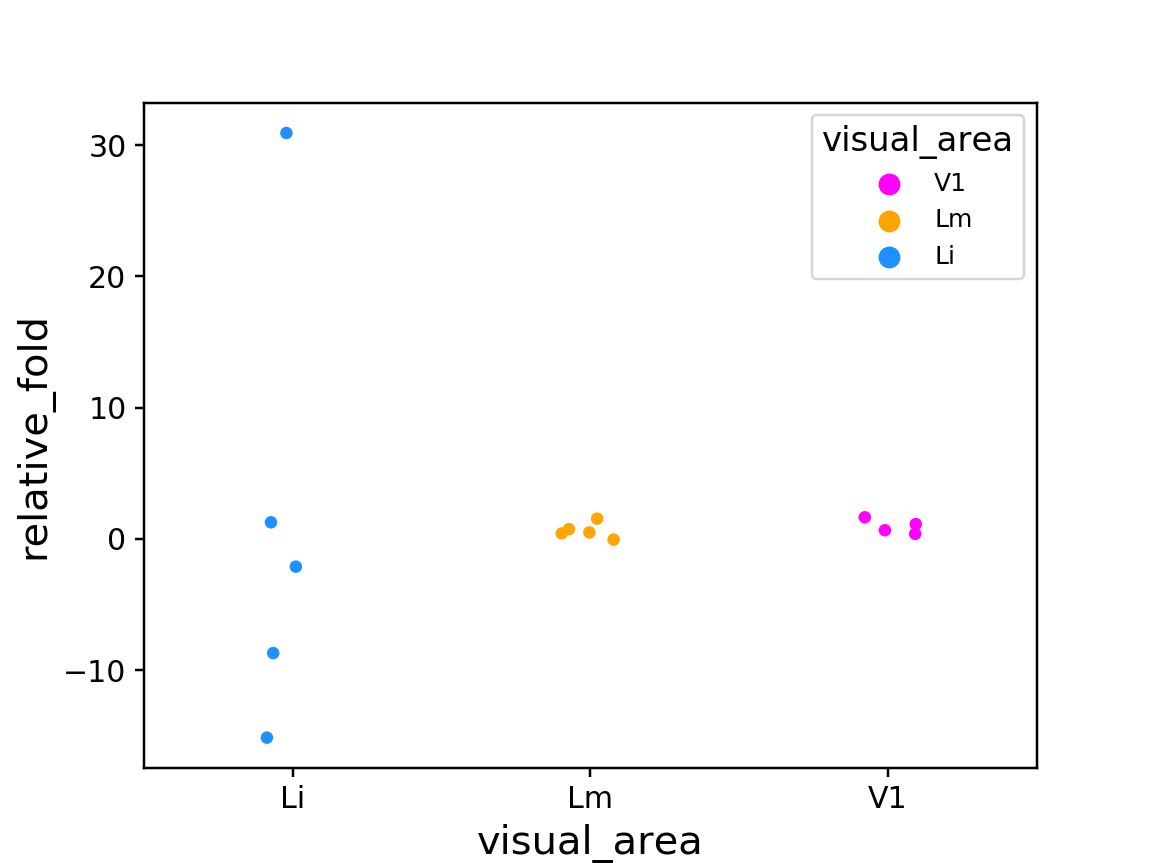

********* [relative_fold] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.270 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.270 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.270 (fdr_bh), reject H0=False
****************************


In [74]:
multi_comp_test='fdr_bh'
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='relative_fold', data=plotd[plotd.arousal=='high'], ax=ax,
            hue='visual_area', palette=area_colors, hue_order=visual_areas)

statresults, ax = aggr.plot_mannwhitney(plotd[plotd.arousal=='high'], metric='relative_fold', 
                                        multi_comp_test=multi_comp_test, ax=ax)


In [75]:
plotd[plotd.arousal=='high'][['visual_area', 'datakey', 'relative_fold']]

visual_area              datakey  relative_fold
19           Li  20190609_JC099_fov1     -15.149468
31           Li  20190614_JC091_fov1       1.257463
37           Li  20190617_JC099_fov1      -2.120906
43           Li  20191018_JC113_fov1      30.921549
49           Li  20191111_JC120_fov1      -8.707095
55           Lm  20190430_JC078_fov1      -0.061173
61           Lm  20190504_JC078_fov1       0.412094
73           Lm  20190508_JC083_fov1       1.534965
103          Lm  20190525_JC084_fov1       0.738762
121          Lm  20190627_JC091_fov1       0.486607
193          V1  20190522_JC084_fov1       1.640350
199          V1  20190613_JC097_fov1       0.379773
205          V1  20190616_JC097_fov1       0.652360
223          V1  20191006_JC110_fov1       1.122504

## Compare input data

In [76]:
print(response_type, responsive_test, responsive_thr)

('dff', 'ROC', 0.05)


In [155]:
#bothpass = putils.split_datakey(bothpass)
xdf = putils.split_datakey(xdf)
# meandf = putils.split_datakey(meandf)

visual_areas=['V1', 'Lm', 'Li']
d_=[]
for (visual_area, animalid, session, fov, datakey), g  \
        in xdf.groupby(['visual_area', 'animalid', 'session', 'fov', 'datakey']):
        
    curr_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, 
                        visual_area=visual_area,
                        response_type=response_type, responsive_test=responsive_test, 
                        overlap_thr=overlap_thr, trial_epoch=trial_epoch)
    
    curr_inputfiles = glob.glob(os.path.join(rootdir, animalid, session, fov,
                        'combined_blobs_static', 'traces',
                       '%s*' % traceid, 'decoding', 'inputdata_%s*.pkl' % curr_id))
    # print("%s: %i files" % (visual_area, len(curr_inputfiles)))
    for cf in curr_inputfiles:
        with open(cf, 'rb') as f:
            res = pkl.load(f)
            
        #res['neuraldf']['arousal']['high_ixs']
        xd = res['neuraldf'].copy()
        xd['arousal'] = 'all'
        xd['arousal'][res['high_ixs']] = 'high'
        xd['arousal'][res['low_ixs']] = 'low'

        tmpdf = pd.melt(xd, id_vars=['config', 'arousal'], 
                          var_name='cell',value_name='response')
        tmpdf['visual_area'] = visual_area
        tmpdf['datakey'] = datakey
        tmpdf['trial'] = tmpdf.index.tolist()
        d_.append(tmpdf)
        
neurald = pd.concat(d_,axis=0)


In [179]:
meandf = putils.split_datakey(meandf)

no_inputfile=[]
pupildf['arousal'] = 'all'

for (visual_area, animalid, session, fov, datakey), g  \
        in meandf.groupby(['visual_area', 'animalid', 'session', 'fov', 'datakey']):
    
    pdf = pupildf[(pupildf.datakey==datakey)].copy()
    #if len(pdf['arousal'].unique()>1):
    #    continue
    curr_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, 
                        visual_area=visual_area,
                        response_type=response_type, responsive_test=responsive_test, 
                        overlap_thr=overlap_thr, trial_epoch=trial_epoch)
    
    curr_inputfiles = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum,
                        'combined_blobs_static', 'traces',
                       '%s*' % traceid, 'decoding', 'inputdata_%s.pkl' % curr_id))
    if len(curr_inputfiles)==0:
        print((visual_area, datakey))
        no_inputfile.append((visual_area, datakey, curr_id))
        continue
        
    assert len(curr_inputfiles)==1, "More than 1 input file: %s" % str(curr_inputfiles)

    with open(curr_inputfiles[0], 'rb') as f:
        res = pkl.load(f)  
    
    for a_type in ['high', 'low']:
        curr_trials = res['%s_ixs' % a_type].astype(int)
        pupildf['arousal'].loc[pdf[pdf['trial'].isin(curr_trials)].index] = a_type
        
no_inputfile   

[]

In [180]:
for dk, g in pupildf.groupby(['datakey']):
    if len(g['arousal'].unique())!=3:
        print(dk, g['arousal'].unique())

In [313]:
# visual_area = 'V1'
# datakey = '20190510_JC083_fov1'
# session, animalid, fovn = putils.split_datakey_str(datakey)

# pdf = pupildf[(pupildf.datakey==datakey)].copy()

# curr_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, 
#                     visual_area=visual_area,
#                     response_type=response_type, responsive_test=responsive_test, 
#                     overlap_thr=overlap_thr, trial_epoch=trial_epoch)
# print(curr_id)
# curr_inputfiles = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum,
#                         'combined_blobs_static', 'traces',
#                        '%s*' % traceid, 'decoding', 'inputdata_%s.pkl' % curr_id))#%s' % curr_id)) 



# assert len(curr_inputfiles)==1, "More than 1 input file: %s" % str(curr_inputfiles)

# with open(curr_inputfiles[0], 'rb') as f:
#     res = pkl.load(f)  

# for a_type in ['high', 'low']:
#     curr_trials = res['%s_ixs' % a_type].astype(int)
#     print(len(curr_trials))
#     pupildf['arousal'].loc[pdf[pdf['trial'].isin(curr_trials)].index] = a_type


### input data:  check distn of stimulus type/size

In [314]:
split = pupildf[pupildf['arousal'].isin(['all', 'high', 'low'])].copy()

p_list=[]
for (visual_area, datakey), g in meandf.groupby(['visual_area', 'datakey']):
    pdf = split[(split.datakey==datakey)].copy()
    tmp0 = pdf[['datakey', 'arousal', 'size', 'morphlevel', 'trial' ]]
    tmp0['visual_area'] = visual_area
    p_list.append(tmp0)
splitdf = pd.concat(p_list, axis=0).reset_index(drop=True)
splitdf.head()

split_counts = splitdf.groupby(['visual_area', 'datakey', 'arousal', 'size', 'morphlevel']).count().reset_index()

In [291]:
# mean_for_size = split_counts[split_counts.arousal.isin(['low', 'high'])]\
#                     .groupby(['visual_area', 'datakey', 'arousal', 'size']).sum().reset_index()

# fig, axn = pl.subplots(1,5, figsize=(8,4), sharex=True, sharey=True)

# for ai, (sz, d_) in enumerate(mean_for_size[mean_for_size['arousal'].isin(['high', 'low'])].groupby(['size'])):
    
#     ax = axn[ai]
#     sns.pointplot(x='visual_area', y='trial', hue='arousal', data=d_, ax=ax, dodge=0.5, join=False,
#                  order=visual_areas, palette='colorblind')
#     ax.set_title(sz)
#     if ai<4:
#         ax.legend_.remove()

In [394]:
curr_dst_dir = os.path.join(dst_dir, 'controls')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/controls


<IPython.core.display.Javascript object>


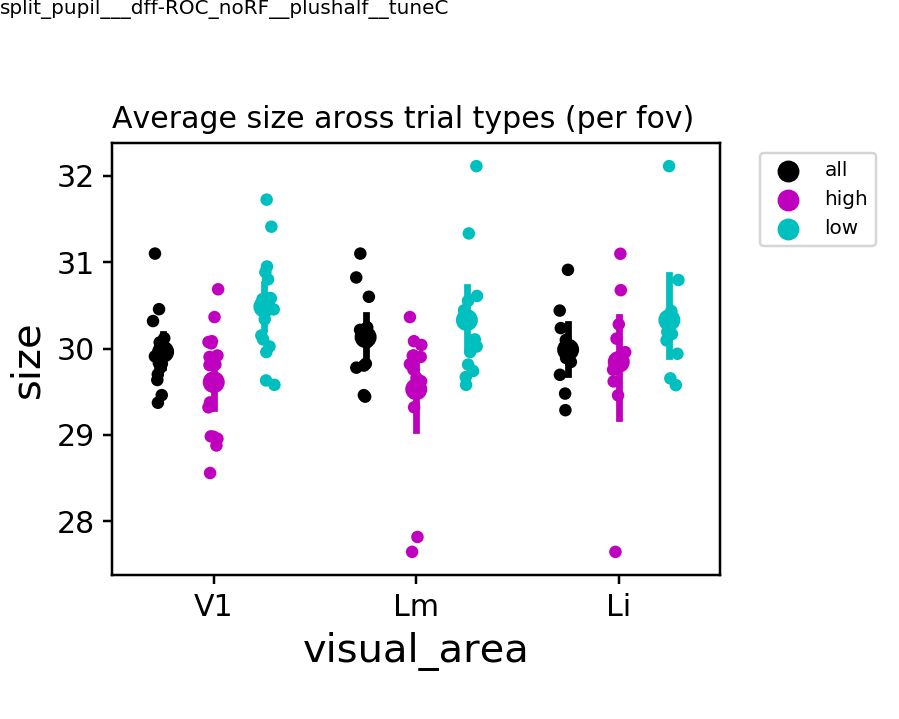

In [398]:
#### Get average size of stimulus across trials in each condition type
mean_size = splitdf.groupby(['visual_area', 'datakey', 'arousal']).mean().reset_index()

fig, ax = pl.subplots(figsize=(5,4))
sns.stripplot(x='visual_area', y='size', hue='arousal', data=mean_size, ax=ax,
             dodge=0.5, palette=arousal_colors, order=visual_areas)
sns.pointplot(x='visual_area', y='size', hue='arousal', data=mean_size, ax=ax,
             dodge=0.5, palette=arousal_colors, order=visual_areas, join=False)
ax.set_title("Average size aross trial types (per fov)", loc='left', fontsize=12)
aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(0.7, 1), loc='upper left', fontsize=8)
pl.subplots_adjust(right=0.8, bottom=0.2, top=0.8)
putils.label_figure(fig, data_id)

figname = 'avg_sizes_by_fov__%s' % data_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


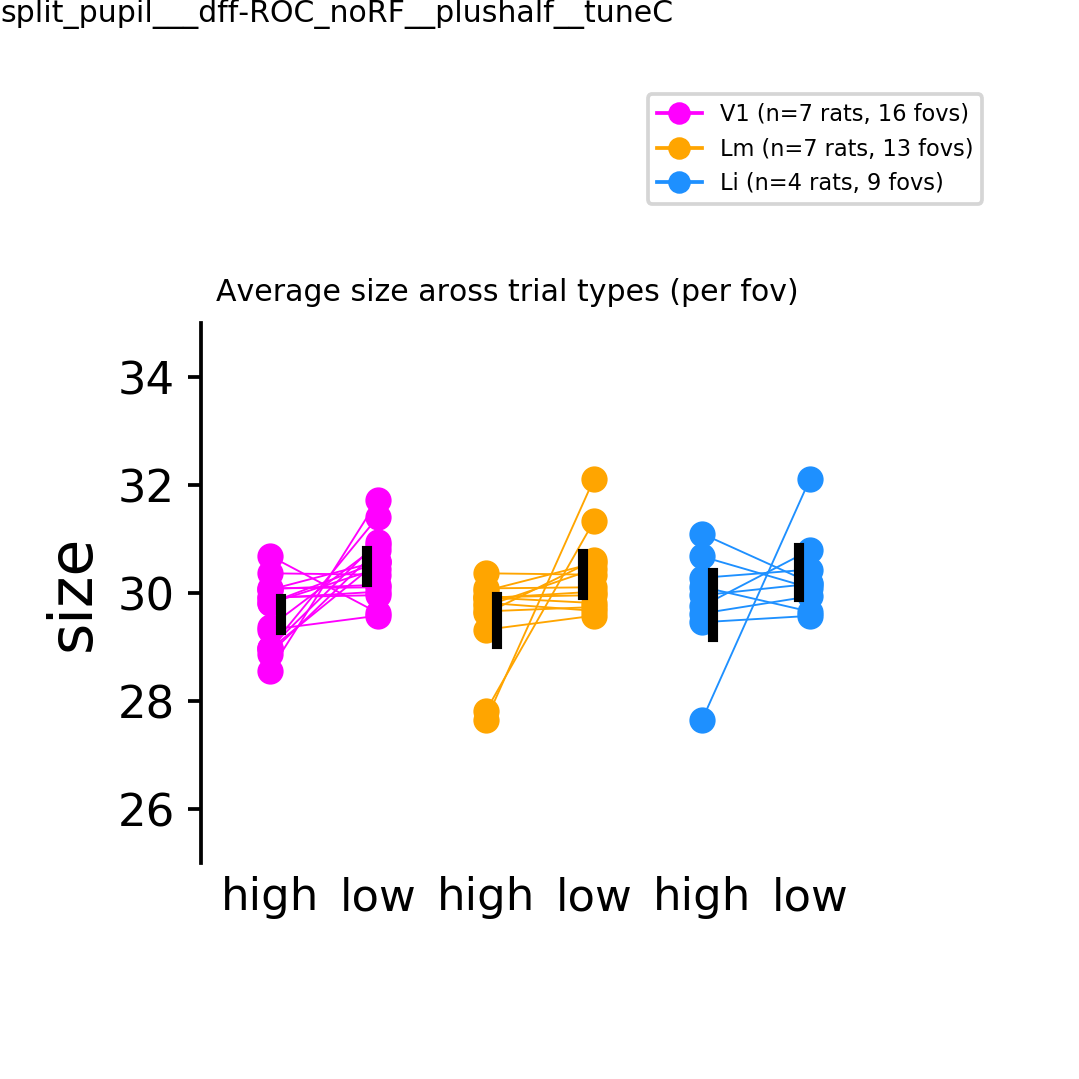

(t-stat:-3.13, p=0.01)
(t-stat:-1.97, p=0.07)
(t-stat:-0.91, p=0.39)


In [399]:
c1='high'
c2='low'
compare_var='arousal'

df_ = mean_size[mean_size['arousal'].isin(['low', 'high'])].copy()

fig, ax = pl.subplots(figsize=(4,4), dpi=dpi)
for aix, visual_area in enumerate(visual_areas):
    plotd = df_[df_['visual_area']==visual_area]
    ax = aggr.plot_paired(plotd, aix=aix, curr_metric='size', c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, color=area_colors[visual_area])
sns.barplot("visual_area", 'size', data=df_, hue=compare_var, hue_order=[c1, c2], #zorder=0,
                ax=ax, order=visual_areas, errcolor='k', edgecolor='none', facecolor='none')
ax.set_xlabel('')

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(df_, area_colors=area_colors,markersize=5, marker='o')
ax.legend(handles=legend_elements, bbox_to_anchor=(1.2,1.2), loc='lower right', fontsize=6)
        
aggr.set_split_xlabels(ax, a_label=c1, b_label=c2)
df_.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fontcolor='k', xytext=(0,125))
ax.set_ylim([25, 35])
ax.set_title("Average size aross trial types (per fov)", loc='left', fontsize=8)

pl.subplots_adjust(bottom=0.2, left=0.2, wspace=0.5, top=0.7, right=0.8)
putils.label_figure(fig, data_id)



figname = 'avg_sizes_paired_by_fov__%s' % data_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


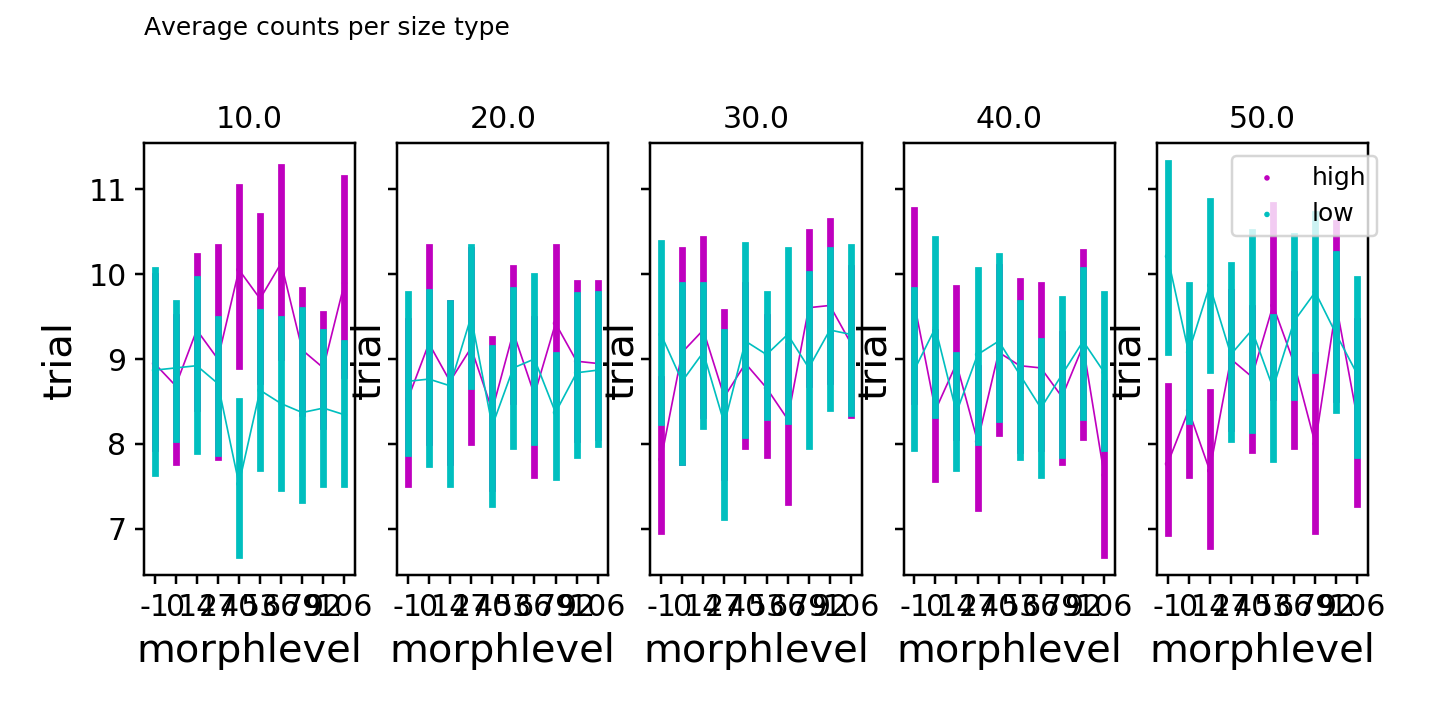

In [400]:
fig, axn = pl.subplots(1,5, figsize=(8,4), sharex=True, sharey=True)
arousal_colors={'all': 'k', 'high': 'm', 'low': 'c'}

for ai, (sz, d_) in enumerate(split_counts[split_counts['arousal'].isin(['high', 'low'])].groupby(['size'])):
    
    ax = axn[ai]
    sns.pointplot(x='morphlevel', y='trial', hue='arousal', data=d_, ax=ax, 
                  dodge=False, join=True, lw=0.5, scale=0.25, palette=arousal_colors)
    ax.legend_.remove()
    ax.set_title(sz)
axn[-1].legend(bbox_to_anchor=(1.1, 1), loc='upper right')
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)

fig.text(0.1, 0.95, "Average counts per size type")


figname = 'counts_by_stim_size__%s' % data_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


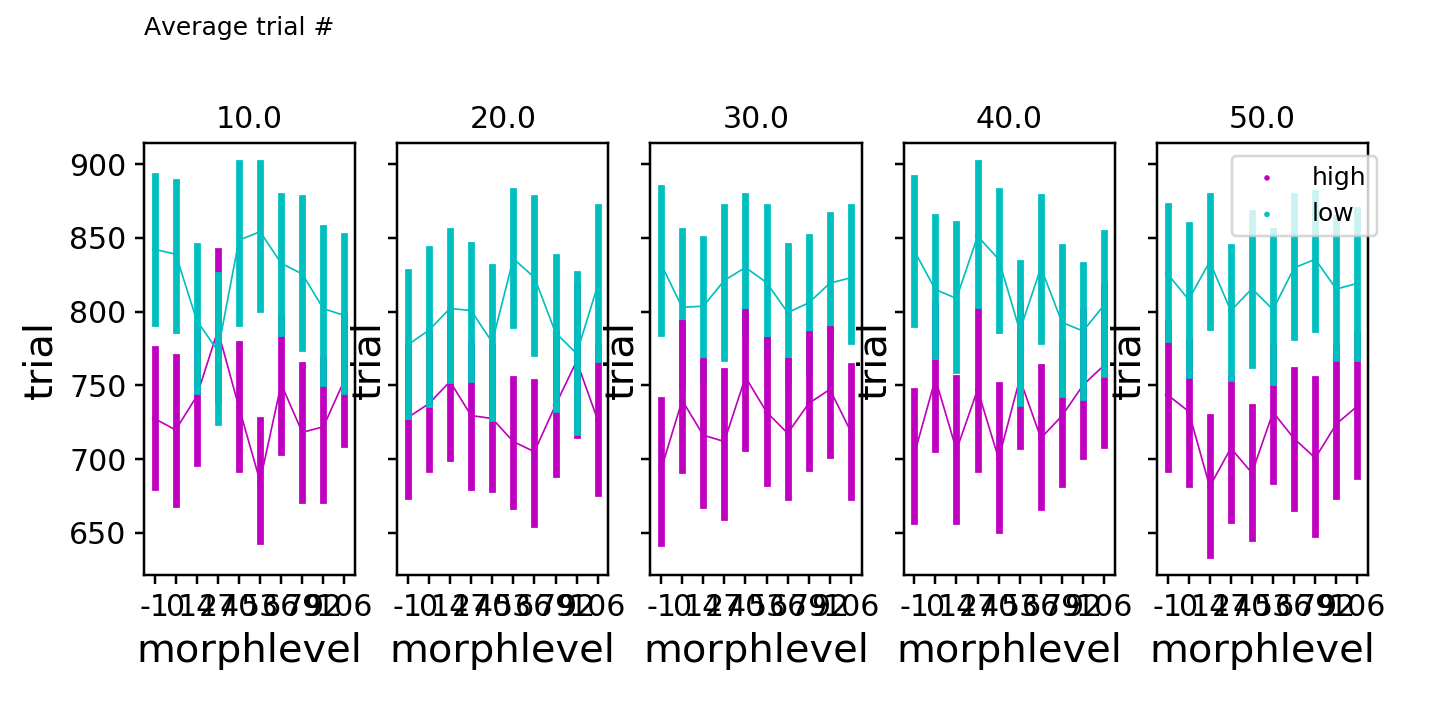

In [401]:
fig, axn = pl.subplots(1,5, figsize=(8,4), sharex=True, sharey=True)
arousal_colors={'all': 'k', 'high': 'm', 'low': 'c'}

for ai, (sz, d_) in enumerate(splitdf[splitdf['arousal'].isin(['high', 'low'])].groupby(['size'])):
    
    ax = axn[ai]
    sns.pointplot(x='morphlevel', y='trial', hue='arousal', data=d_, ax=ax, 
                  dodge=False, join=True, lw=0.5, scale=0.25, palette=arousal_colors)
    ax.legend_.remove()
    ax.set_title(sz)
axn[-1].legend(bbox_to_anchor=(1.1, 1), loc='upper right')
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)

fig.text(0.1, 0.95, "Average trial #")


figname = 'trialnum_by_stim_size__%s' % data_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

# Response magnitudes

In [402]:
means_by_cell = neurald.groupby(['visual_area', 'datakey', 'cell', 'arousal' ]).mean().reset_index()
means_by_cell.head()

means_by_fov = means_by_cell.groupby(['visual_area', 'datakey', 'arousal' ]).mean().reset_index()
means_by_fov.head()

visual_area              datakey arousal        cell  response         trial
0          Li  20190609_JC099_fov1     all  195.192982 -0.006345  42656.183303
1          Li  20190609_JC099_fov1    high  195.192982  0.063200  42957.054737
2          Li  20190609_JC099_fov1     low  195.192982 -0.055957  42649.983122
3          Li  20190614_JC091_fov1     all  198.974359 -0.013605  58404.467181
4          Li  20190614_JC091_fov1    high  198.974359  0.034862  58627.796334

<IPython.core.display.Javascript object>


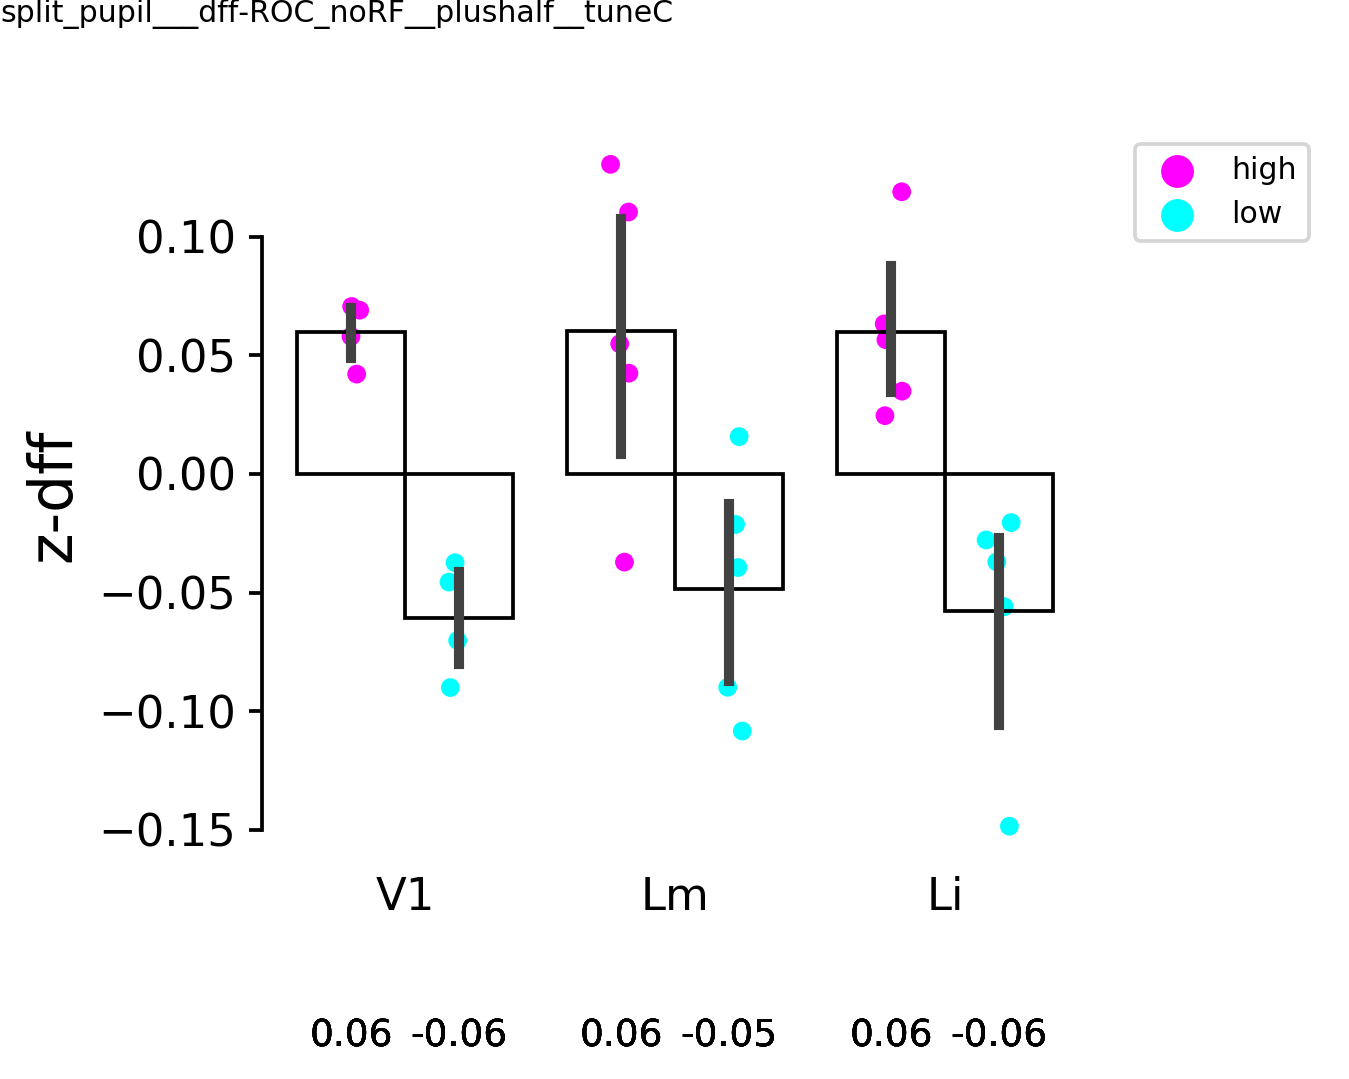

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/controls', 'mean_dff_by_fov__filtered__split_pupil___dff-ROC_noRF__plushalf__tuneC')


In [404]:
palette=['magenta', 'cyan']
plot_cells=False

if plot_cells:
    plotdf = means_by_cell[means_by_cell['arousal'].isin(['high', 'low'])].copy()
else:
    plotdf = means_by_fov[means_by_fov['arousal'].isin(['high', 'low'])].copy()

markersize=2 if plot_cells else 5
plot_str='all_cells' if plot_cells else 'by_fov'

fig, ax = pl.subplots(dpi=dpi, figsize=(5,4))

sns.stripplot(x='visual_area', y='response', hue='arousal', data=plotdf, ax=ax, 
              palette=palette, dodge=True, zorder=-1, order=visual_areas, size=markersize)
sns.barplot(x='visual_area', y='response', hue='arousal', data=plotdf, ax=ax, zorder=-1, 
            edgecolor=('k', 'k', 'k'), facecolor='none', order=visual_areas)
plotdf.apply(aggr.annotateBars, ax=ax,fontsize=10, fontcolor='k', xytext=(0, -150))

#ax.set_ylim([-1, 2])
sns.despine(trim=True, offset=2, bottom=True)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
ax.set_ylabel('z-dff')

pl.subplots_adjust(left=0.2, bottom=0.2, right=0.8)
aggr.crop_legend_labels(ax, n_hues=2, bbox_to_anchor=(1., 1), fontsize=8)

putils.label_figure(fig, data_id)
#ax.set_ylim([-1, 2])
figname = 'mean_dff_%s__filtered__%s' % (plot_str, data_id)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


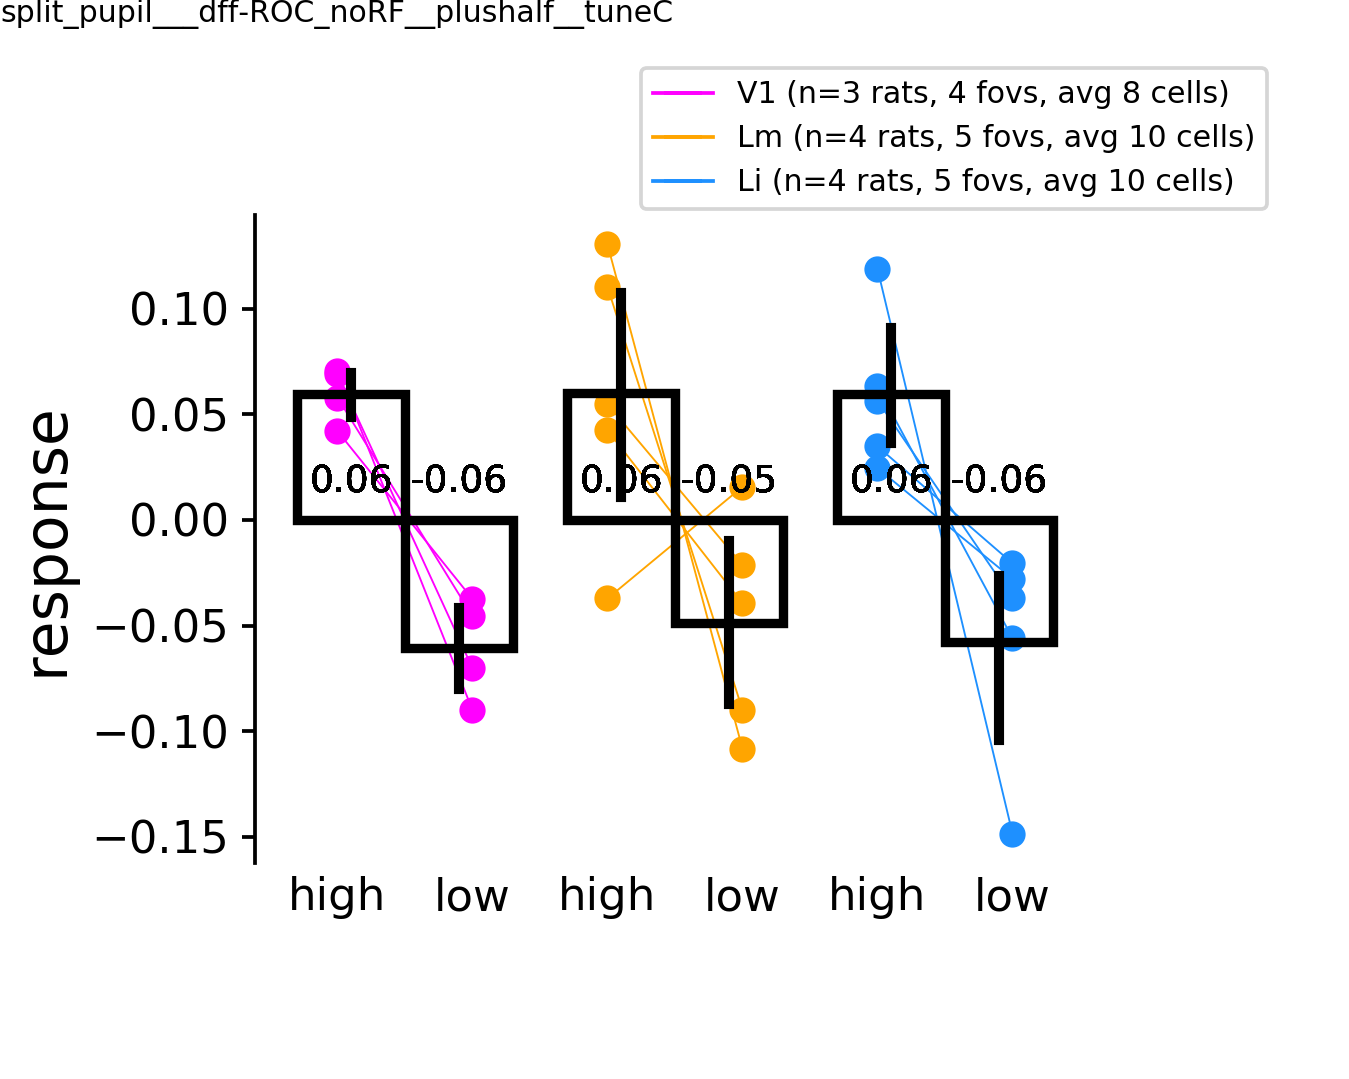

(t-stat:6.67, p=0.01)
(t-stat:2.11, p=0.10)
(t-stat:2.98, p=0.04)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/controls', 'mean_dff_paired_by_fov__filtered__split_pupil___dff-ROC_noRF__plushalf__tuneC')


In [405]:
c1='high'
c2='low'
compare_var='arousal'

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
ax = aggr.plot_pairwise_by_axis(plotdf, curr_metric='response', c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=True, bbox_to_anchor=(1.25, 1.25))
putils.label_figure(fig, data_id)
pl.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8)
ax.set_xlabel('')

figname = 'mean_dff_paired_%s__filtered__%s' % (plot_str, data_id)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

# Quality control checks

<IPython.core.display.Javascript object>


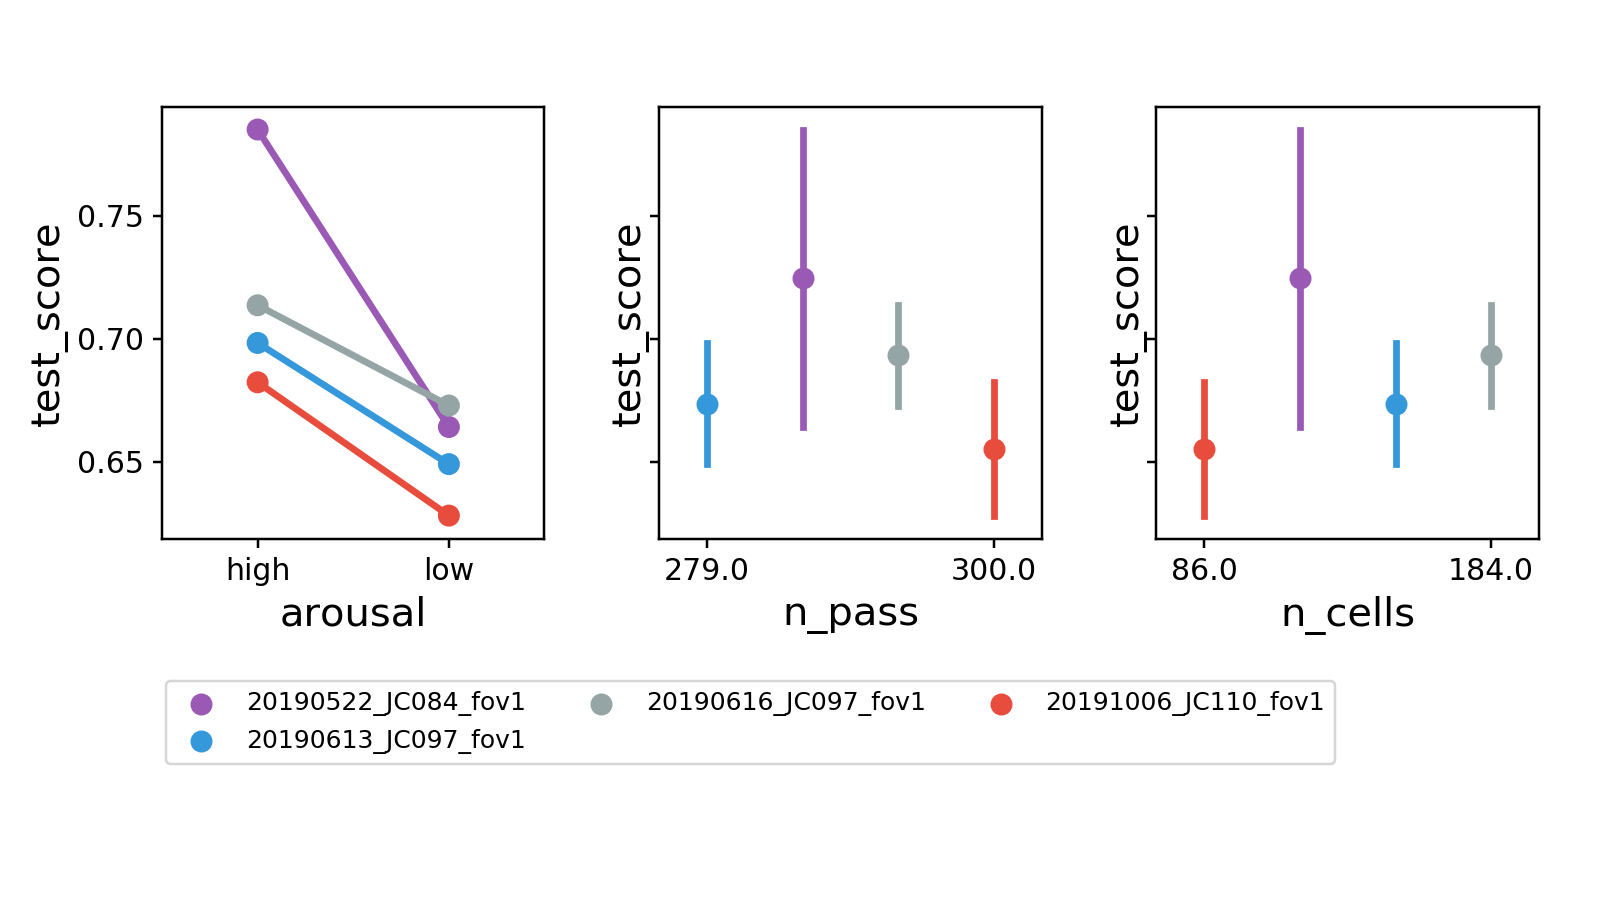

In [90]:
metric='test_score'
min_ncells=10
min_frac=0.5
visual_area='V1'
plotd = xdf[(xdf['visual_area']==visual_area) & (xdf['condition']=='data')
                 & (xdf['n_cells']>=min_ncells) & (xdf['fraction_missing']<=min_frac)]

#p_ = plotd[(plotd['fraction_missing']<0.4) & (plotd['n_cells']>40)]


fig, axn = pl.subplots(1, 3, figsize=(9,5), sharey=True)

ax=axn[0]
sns.pointplot(x='arousal', y=metric, hue='datakey', data=plotd, ax=ax)
ax.legend_.remove()


ax=axn[1]
#x.scatter(plotd['n_missing'], plotd[metric])
#plotd = passdf[(passdf['visual_area']=='V1') & (passdf['condition']=='data') & (passdf['arousal']=='all')]
sns.pointplot(x='n_pass', y=metric, hue='datakey', data=plotd, ax=ax)
ax.legend_.remove()

xticks = ax.get_xticks()
xtick_labels = ax.get_xticklabels()
ax.set_xticks(xticks[0::3])
ax.set_xticklabels([round(float(i.get_text()), 1) for i in xtick_labels[0::2]])

ax=axn[2]
sns.pointplot(x='n_cells', y=metric, hue='datakey', data=plotd, ax=ax)

xticks = ax.get_xticks()
xtick_labels = ax.get_xticklabels()
ax.set_xticks(xticks[0::3])
ax.set_xticklabels(xtick_labels[0::3])

ax.legend(bbox_to_anchor=(0.5, -0.3), ncol=3)

pl.subplots_adjust(left=0.1, right=0.95, wspace=0.3, bottom=0.4)

In [255]:
plotd.head()

visual_area              datakey condition arousal         C  fit_time  \
133          V1  20190501_JC076_fov1      data    high   1.11034  0.000635   
134          V1  20190501_JC076_fov1      data     low   0.50752  0.000521   
175          V1  20190512_JC083_fov1      data    high   3.53440  0.001359   
176          V1  20190512_JC083_fov1      data     low  29.06713  0.006622   
187          V1  20190522_JC084_fov1      data    high   0.03880  0.000907   

     heldout_MI  heldout_aMI  heldout_log2MI  heldout_test_score  \
133    0.043875     0.005383        0.063298            0.580714   
134    0.024059    -0.001602        0.034710            0.589286   
175    0.014278    -0.002692        0.020599            0.498235   
176    0.028373     0.002773        0.040933            0.566500   
187    0.236671     0.312963        0.341443            0.800000   

           ...          test_score  train_score  n_cells  n_trials  iteration  \
133        ...            0.588009     0.883730     33.0      67.0       49.5   
134        ...            0.625655     0.797239     33.0      67.0       49.5   
175        ...            0.528495     0.687433     28.0      83.0       49.5   
176        ...            0.578627     0.860733     28.0      97.0       49.5   
187        ...            0.781495     0.961402    107.0      90.0       49.5   

     fraction_missing  n_missing  n_pass  feature_sample_ratio  \
133          0.333333        100     200              0.165000   
134          0.333333        100     200              0.165000   
175          0.093548         29     281              0.099644   
176          0.093548         29     281              0.099644   
187          0.030000          9     291              0.367698   

     fold_over_shuffle  
133           0.113699  
134           0.061776  
175          -0.066152  
176           0.121782  
187           0.525424  

[5 rows x 21 columns]

In [256]:
import matplotlib.ticker as ticker


In [ ]:
plotd['feature_sample_ratio'] = plotd['n_cells']/plotd['n_pass']

In [ ]:
plotd['n_cells']

In [ ]:


fig, axn = pl.subplots(1, 2, figsize=(8,4), sharex=False)
ax=axn[0]
sns.scatterplot(x='n_cells', y='fraction_missing', hue='datakey', data=plotd, ax=ax, s=100)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.legend_.remove()

ax=axn[1]
sns.scatterplot(x='feature_sample_ratio', y=metric, hue='datakey', data=plotd, ax=ax, s=100)
ax.legend(bbox_to_anchor=(1.1, 1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x)))


pl.subplots_adjust(bottom=0.2, wspace=0.3, right=0.8, left=0.1)

In [ ]:
xlabels

In [ ]:
plotd[['datakey', 'arousal', 'n_trials', 'test_score', 'n_pass', 'n_cells', 'feature_sample_ratio']]

In [ ]:
fig, axn = pl.subplots(1,2)
ax=axn[0]
sns.pointplot(x='arousal', y=metric, hue='datakey', data=plotd, ax=ax)
ax.legend_.remove()


ax=axn[1]
sns.pointplot(x='arousal', y='n_cells', hue='datakey', data=plotd, ax=ax)
ax.legend_.remove()

print(plotd[plotd['n_cells']<70]['datakey'])

In [ ]:
min_ncells=5

bad_training = df[df['test_score']<0.25]['datakey'].unique()
few_cells = df[df['n_cells']<min_ncells]['datakey'].unique()

excluded = np.union1d(bad_training, few_cells)

print("Excluding %i datakeys for bad training: %s" % (len(bad_training), str(bad_training)))
print("Excluding %i datakeys for too few cells: %s" % (len(few_cells), str(few_cells)))


In [ ]:
meandf = df.groupby(['visual_area', 'datakey', 'condition', 'arousal']).mean().reset_index()
meandf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

In [ ]:
metric='heldout_log2MI'
plotdf = meandf[meandf['arousal'].isin(['low', 'high'])].copy()

fig, axn = pl.subplots(1,2, sharey=True)

ax=axn[0]; ax.set_title('data')
df_ = plotdf[plotdf['condition']=='data'].copy()
sns.barplot(x='visual_area', y=metric, data=df_,
              hue='arousal', dodge=True, ax=ax) #, pl.figure()

ax=axn[1]; ax.set_title('shuffled')
df_ = plotdf[plotdf['condition']=='shuffled'].copy()
sns.barplot(x='visual_area', y=metric, data=df_,
              hue='arousal', dodge=True, ax=ax) #, pl.figure()


## Check N trials per cond?

In [ ]:
ntrials_score = df.groupby(['datakey', 'arousal'])['heldout_test_score', 'n_trials'].mean().reset_index()

In [ ]:
fig, ax = pl.subplots(figsize=(4,3))

x1=ntrials_score[ntrials_score['arousal']=='high']
sns.regplot(x1['n_trials'], x1['heldout_test_score'], label='high')

x2=ntrials_score[ntrials_score['arousal']=='low']
sns.regplot(x2['n_trials'], x2['heldout_test_score'], label='low')

pl.legend()

## Check significance

In [ ]:
s_=[]
for (visual_area, datakey), d_ in df[df['arousal']=='all'].groupby(['visual_area', 'datakey']):
                            
    mean_score = d_[d_['condition']=='data'][metric].mean()
    percentile = np.mean(mean_score < d_[d_['condition']=='shuffled'][metric])
    
    s = pd.Series({'visual_area': visual_area, 'datakey': datakey, 
                   'mean_score': mean_score, 'percentile': percentile})
    s_.append(s)
    
scores = pd.concat(s_, axis=1).T

In [ ]:
visual_area='Li'
scores[scores['visual_area']==visual_area]

In [ ]:
df[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area'])['datakey'].count()


In [ ]:
area_dkeys = edata[edata['visual_area']=='V1']['datakey'].unique()
[k for k in area_dkeys if k not in df[df['visual_area']=='V1']['datakey'].unique()]
## NO cells.

In [ ]:
visual_area='Li'

plotdf = df[(df['arousal']=='all')] #& (df['visual_area']==visual_area)]

## plot
fig, axn = pl.subplots(3, 11, figsize=(10,5), sharex=True, sharey=True)
ai=0
prev_vi=0
for (visual_area, datakey), d_ in plotdf.groupby(['visual_area', 'datakey']):
    vi = visual_areas.index(visual_area)
    if prev_vi!=vi:
        ai=0
    ax = axn[vi, ai]
    if ai==0:
        ax.text(-0.3, 0.5*ai, visual_area)
        
    d_ = df[(df['arousal']=='all') & (df['datakey']==datakey) & (df['visual_area']==visual_area)]
    n_cells = d_['n_cells'].unique()[0]
    
    metric = 'heldout_test_score'
    
    sns.distplot(d_[d_['condition']=='data'][metric], ax=ax, bins=20, color='m')
    sns.distplot(d_[d_['condition']=='shuffled'][metric], ax=ax, bins=20, color='k')

    ax.set_title('%s\n(%i cells)' % (datakey, n_cells), fontsize=6, loc='left')
    #ax.axis('off')
    ai+=1
    prev_vi=vi
    
pl.subplots_adjust(left=0.05, right=0.95, wspace=0.5, hspace=0.5)

for ax in axn.flat:
    ax.axvline(x=0.5, linestyle=':', color='k')
    ax.axis('off')

## Threshold performance

In [ ]:
p_thr=0.01
pass_scores = scores[scores['percentile']<=p_thr]
pass_scores[pass_scores['visual_area']==visual_area]


In [ ]:
exclude_for_face ={'V1': ['20190510_JC083_fov1', '20190622_JC085_fov1', '20190617_JC097_fov1'],
                         #'20190507_JC083_fov1', '20190511_JC083_fov1'],
                  'Lm': ['20190506_JC080_fov1', '20190512_JC083_fov1'], 
                   'Li': []} #['20190502_JC076_fov1', '20191105_JC117_fov1', 
                          #'20190602_JC091_fov1', '20190606_JC091_fov1', '20190607_JC091_fov1'] }

#
visual_area='Li'

pass_dkeys = pass_scores[(pass_scores['visual_area']==visual_area)]['datakey'].unique()
exclude = list(meandf[~meandf['datakey'].isin(pass_dkeys)]['datakey'].unique())
exclude.extend(exclude_for_face[visual_area])

vdf = meandf[(meandf['visual_area']==visual_area) 
         & (~meandf['datakey'].isin(exclude))
         & (meandf['condition']=='data')]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']
fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):
    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)
    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3), fontsize=8)
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5, left=0.1)
fig.suptitle(visual_area)

print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)

figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
#pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

In [ ]:
dst_dir

In [ ]:
os.listdir(dst_dir)


# plotting

In [239]:
v1_exclude = ['20190510_JC083_fov1', '20190511_JC083_fov1', '20190507_JC083_fov1', '20190617_JC097_fov1', '20190622_JC085_fov1']
lm_exclude=['20190506_JC080_fov1', '20190512_JC083_fov1', '20190513_JC078_fov1', '20190603_JC080_fov1']
li_exclude=['20190502_JC076_fov', '20190602_JC091_fov1', '20190606_JC091_fov1', '20190607_JC091_fov1']


exclude = [v1_exclude, lm_exclude, li_exclude, excluded]
bad_dsets = [l for sublist in exclude for l in sublist ]
len(bad_dsets)

13

<IPython.core.display.Javascript object>


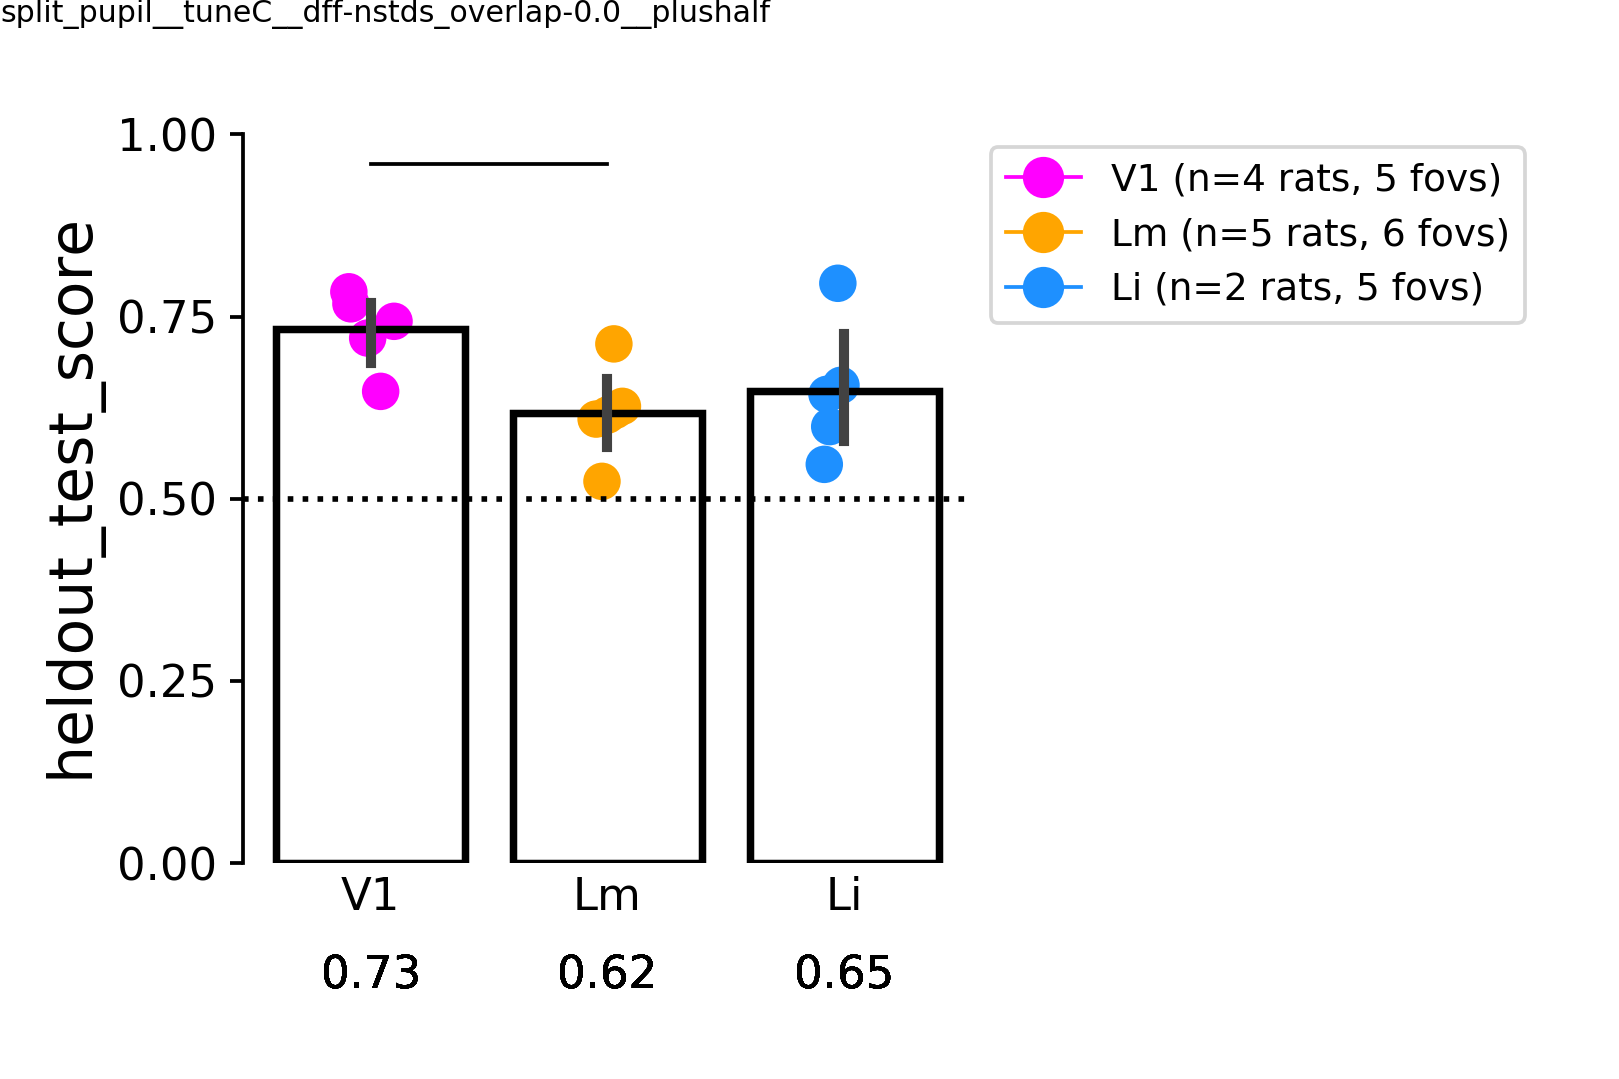

********* [heldout_test_score] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.021 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.158 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.324 (fdr_bh), reject H0=False
****************************


In [47]:
metric = 'heldout_test_score'
#metric='heldout_log2MI'
multi_comp_test='fdr_bh'

f, ax = pl.subplots(dpi=dpi, figsize=(6,4))
f.patch.set_alpha(1)

plotdf = df[~df['datakey'].isin(exclude)].copy()


if 'pupil' in analysis_type:
    xdf = plotdf[plotdf['arousal']=='all']
else:
    xdf = plotdf.copy()

sns.barplot(x='visual_area', y=metric, data=xdf, ax=ax, order=visual_areas,
             edgecolor=('k', 'k', 'k'), facecolor='none', lw=2)

sns.stripplot(x='visual_area', y=metric, data=xdf, ax=ax,
             palette=area_colors, order=visual_areas, zorder=1, s=10)

xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))

ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')

statsresults, ax = aggr.plot_mannwhitney(xdf, metric=metric, multi_comp_test=multi_comp_test, ax=ax)

leg = aggr.get_counts_for_legend(xdf, area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1., 1))

if metric=='heldout_test_score':
    ax.set_yticks(np.linspace(0, 1, 5))
    sns.despine(ax=ax, trim=True)
    ax.axhline(y=0.5, ls=':', c='k')
sns.despine(bottom=True)
 
putils.label_figure(f, data_id)
pl.subplots_adjust(left=0.15, bottom=0.2, right=0.6)


# figname = 'overall_%s__%s' % (metric, data_id)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)

<IPython.core.display.Javascript object>


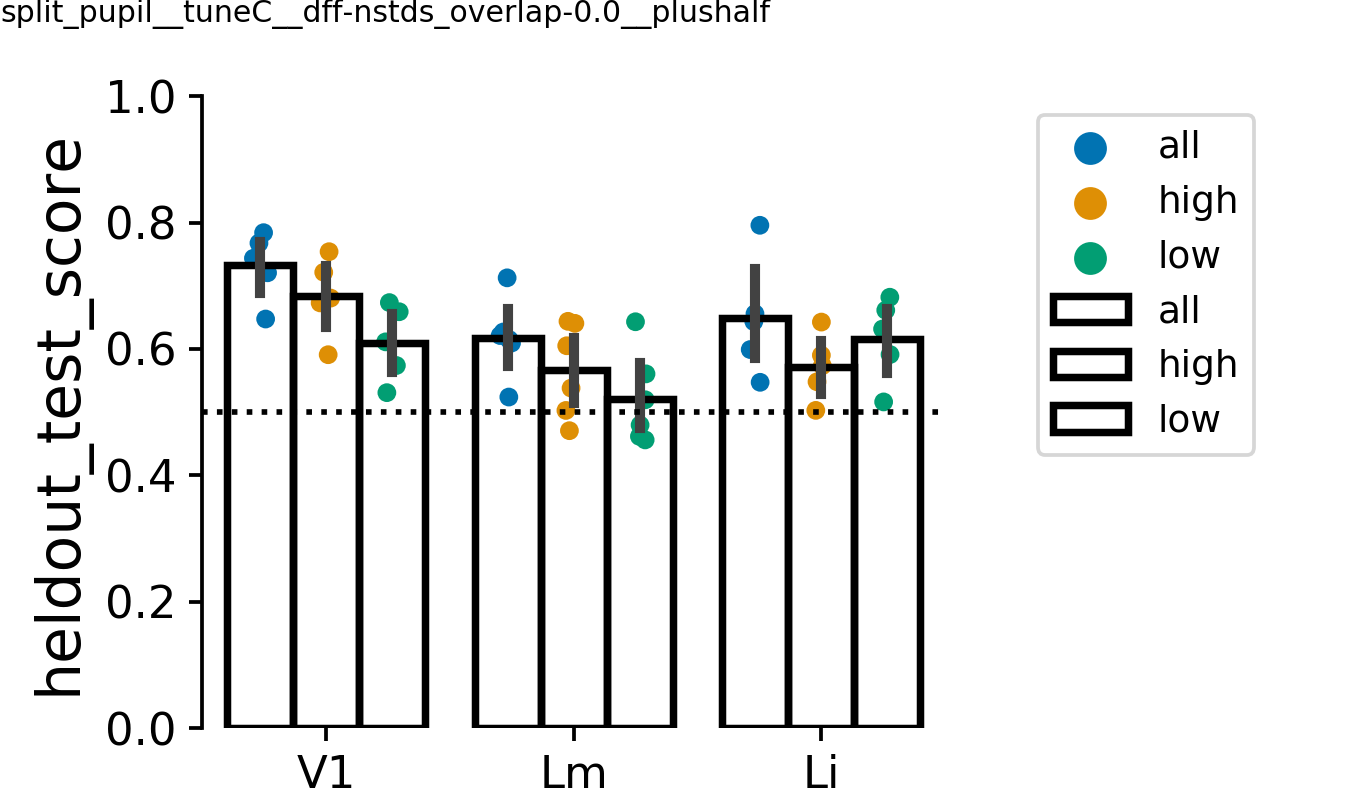

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'split_low-v-high_heldout_test_score__split_pupil__tuneC__dff-nstds_overlap-0.0__plushalf')


In [48]:
if 'pupil' in analysis_type:
    metric='heldout_test_score'
    f, ax = pl.subplots(dpi=dpi, figsize=(5,3))
    f.patch.set_alpha(1)

    sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax, hue='arousal',
                order=visual_areas,
                 edgecolor=('k', 'k', 'k'), facecolor='none', lw=2)

    sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax, hue='arousal',
                 palette='colorblind', order=visual_areas, zorder=1, s=5, dodge=True)

    sns.despine(bottom=True, ax=ax)
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, ls=':', c='k')
    ax.legend(bbox_to_anchor=(1.1, 1))

    putils.label_figure(f, data_id)
    pl.subplots_adjust(right=0.7, bottom=0.1, left=0.15)

    figname = 'split_low-v-high_%s__%s' % (metric, data_id)
    #pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

In [32]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov'

In [201]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

<IPython.core.display.Javascript object>


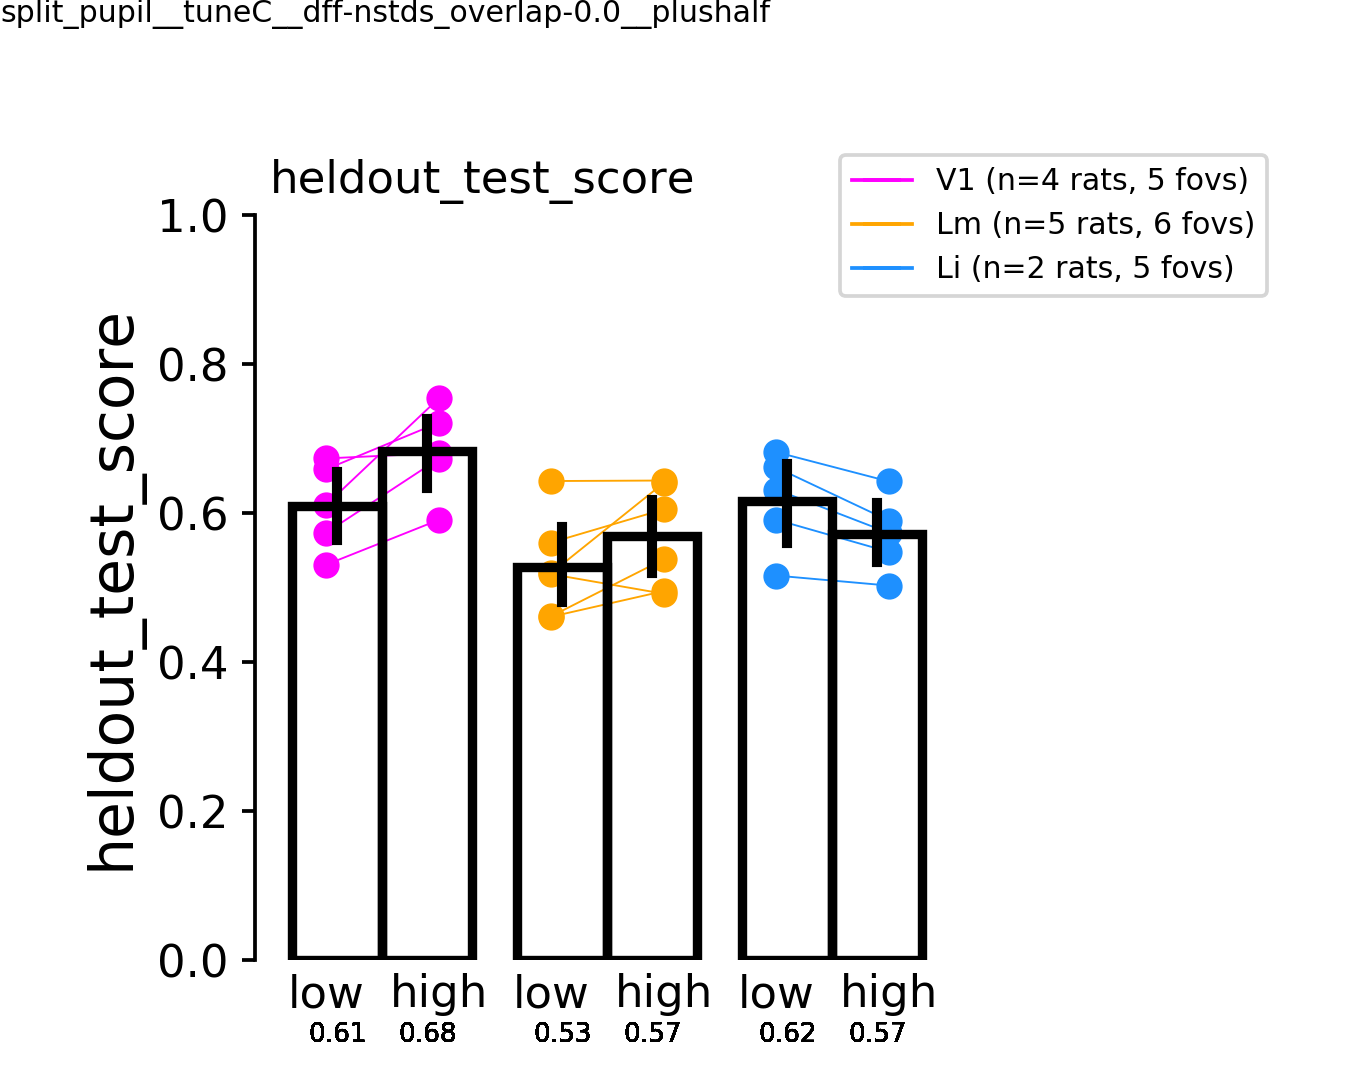

V1: (t-stat:-3.30, p=0.03)
Lm: (t-stat:-1.94, p=0.11)
Li: (t-stat:4.63, p=0.01)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_heldout_test_score__tuneC')


<IPython.core.display.Javascript object>


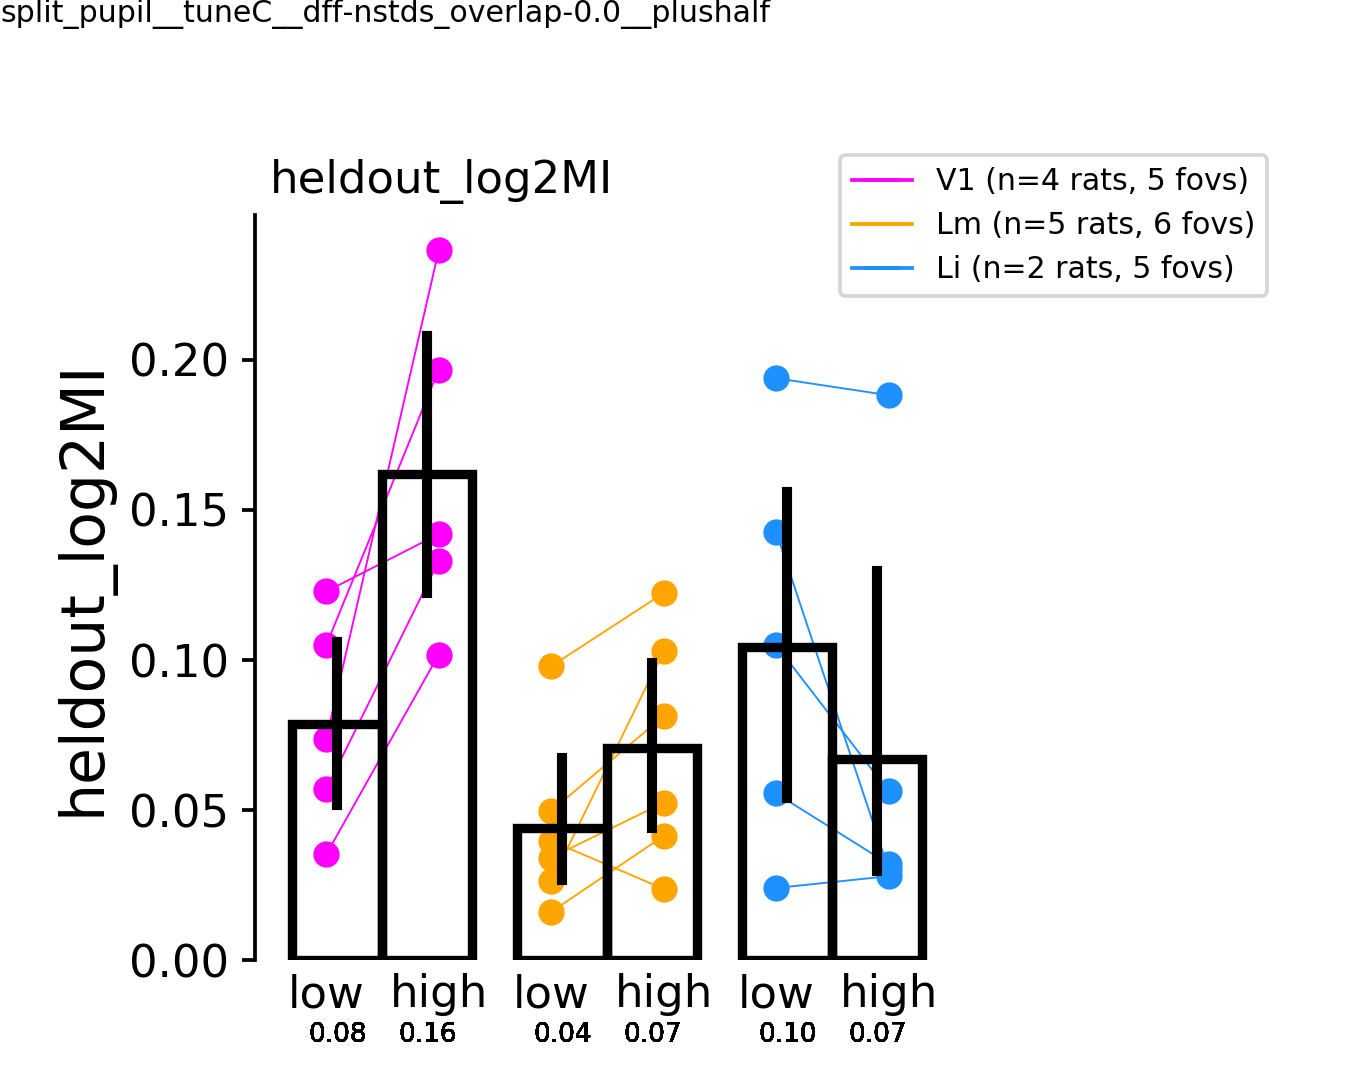

V1: (t-stat:-3.58, p=0.02)
Lm: (t-stat:-2.20, p=0.08)
Li: (t-stat:1.79, p=0.15)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_heldout_log2MI__tuneC')


<IPython.core.display.Javascript object>


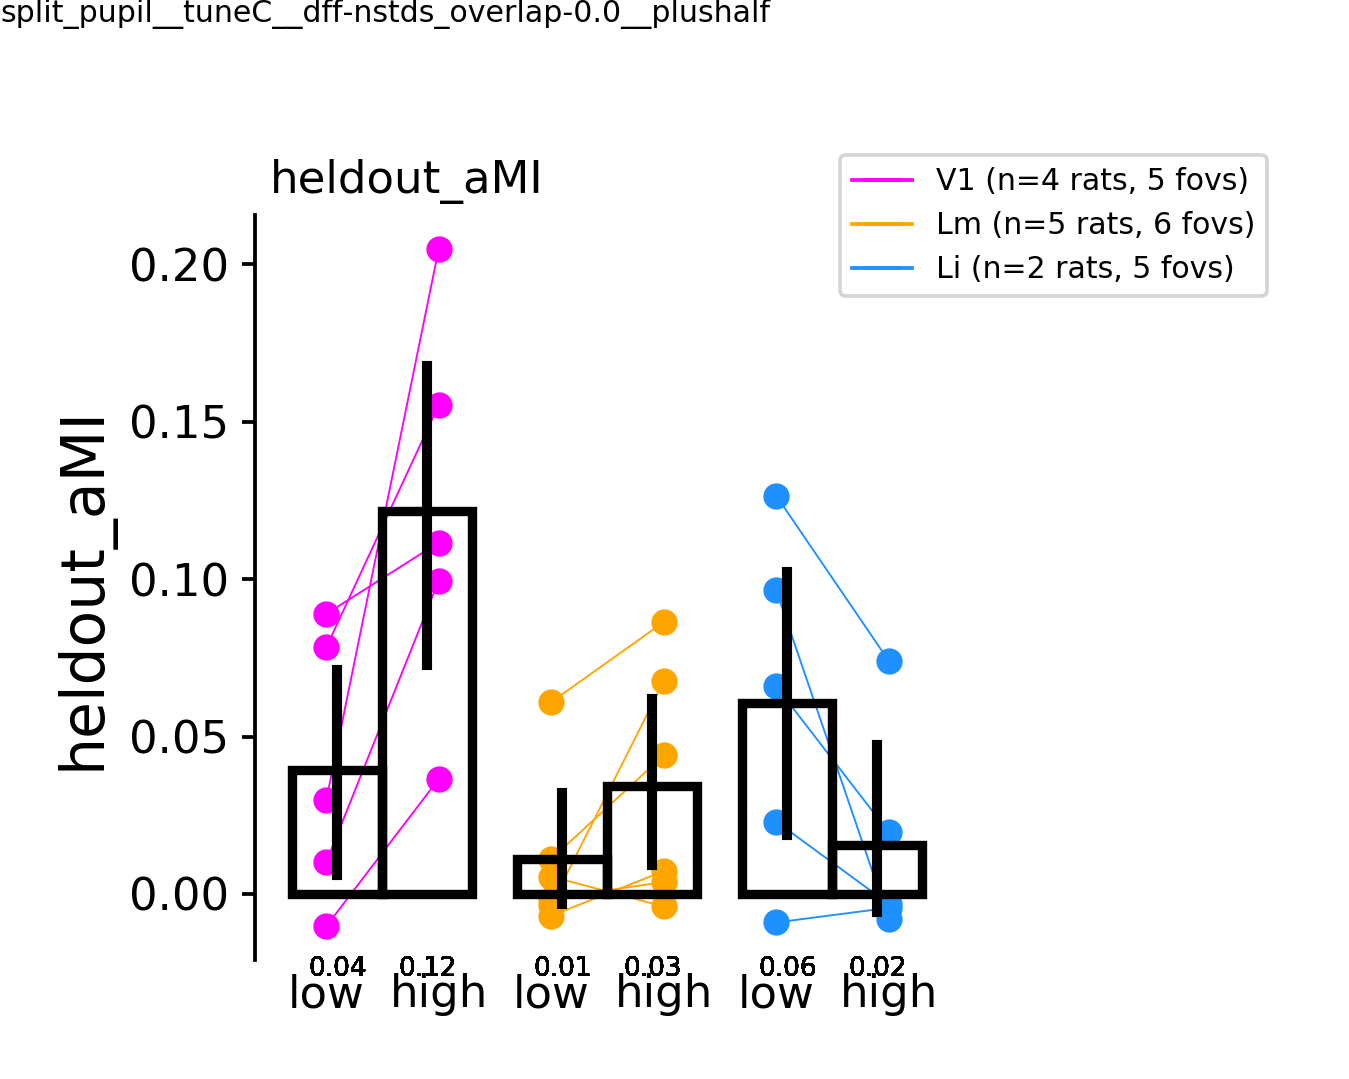

V1: (t-stat:-3.16, p=0.03)
Lm: (t-stat:-2.05, p=0.10)
Li: (t-stat:2.51, p=0.07)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_heldout_aMI__tuneC')


<IPython.core.display.Javascript object>


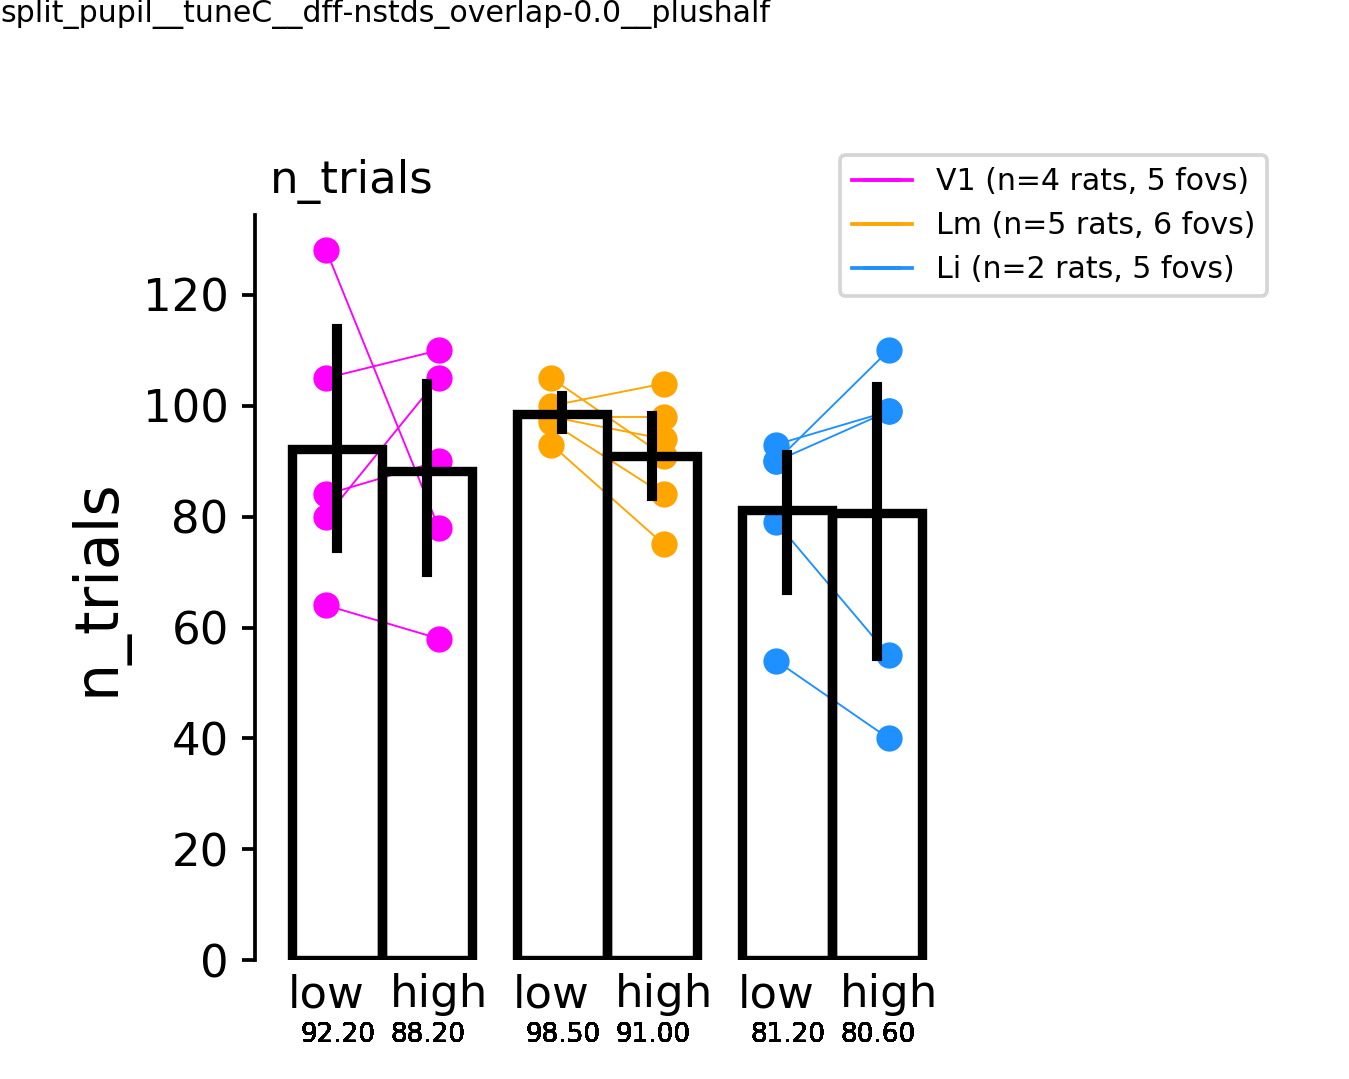

V1: (t-stat:0.32, p=0.77)
Lm: (t-stat:2.10, p=0.09)
Li: (t-stat:0.07, p=0.94)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_n_trials__tuneC')


In [196]:
metric = 'heldout_test_score'
#metric = 'abs_coef'
plotdf = df[~df['datakey'].isin(exclude)].copy()

currdf = plotdf[(plotdf['arousal'].isin(['low', 'high'])) & (~plotdf['datakey'].isin(exclude))]


for metric in ['heldout_test_score', 'heldout_log2MI','heldout_aMI', 'n_trials']:
    fig = aggr.plot_pairwise_by_axis(currdf, curr_metric=metric, c1='low', c2='high', compare_var='arousal',
                               area_colors=area_colors, fontsize=7, fontcolor='k', fmt='%.2f', xytext=(0, -20))
    pl.subplots_adjust(left=0.2, right=0.7, top=0.8)
    fig.axes[0].set_title(metric, loc='left')
    
    if metric=='heldout_test_score':
        fig.axes[0].set_ylim([0, 1])
    putils.label_figure(fig, data_id)
    
    figname = 'paired_low-v-high_%s__%s' % (metric, C_str)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

<IPython.core.display.Javascript object>


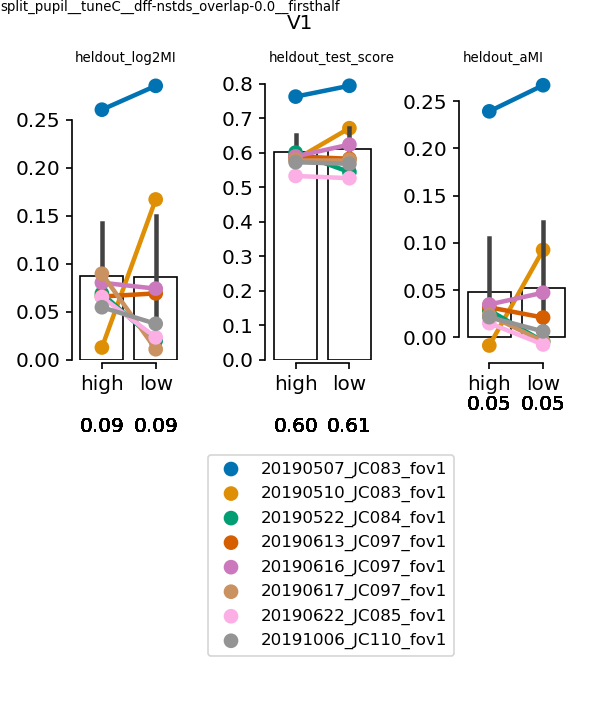

STATS - V1
heldout_log2MI--------------------
Paired t-test, t=-0.05 (p=0.96)
heldout_test_score--------------------
Paired t-test, t=0.68 (p=0.52)
heldout_aMI--------------------
Paired t-test, t=0.26 (p=0.81)
test_metrics_V1_color-datakeys__split_pupil__tuneC__dff-nstds_overlap-0.0__firsthalf


In [241]:
exclude =[] #copy.copy(v1_exclude)
#exclude=[]
visual_area='V1'

vdf = df[(df['visual_area']==visual_area) & (~df['datakey'].isin(exclude))]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)

    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))

    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3))
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5)
fig.suptitle(visual_area)

#
print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)


figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
#|pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

<IPython.core.display.Javascript object>


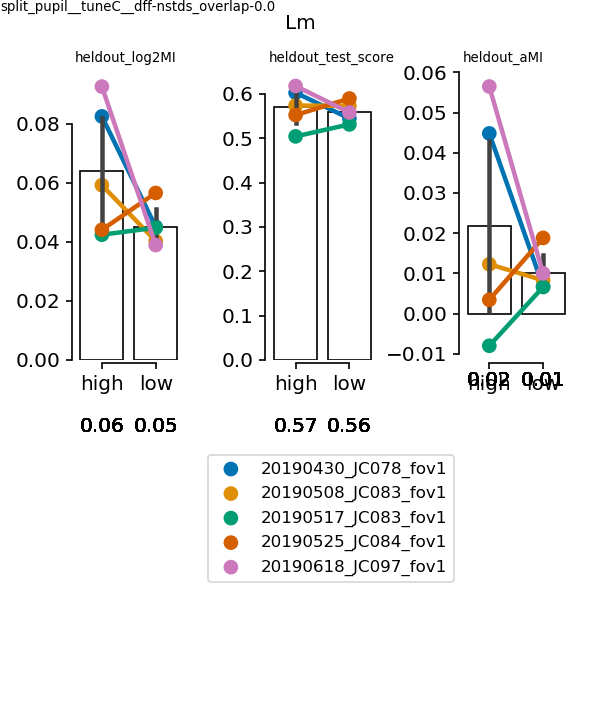

STATS - Lm
heldout_log2MI--------------------
Paired t-test, t=-1.56 (p=0.19)
heldout_test_score--------------------
Paired t-test, t=-0.52 (p=0.63)
heldout_aMI--------------------
Paired t-test, t=-0.90 (p=0.42)
test_metrics_Lm_color-datakeys__split_pupil__tuneC__dff-nstds_overlap-0.0


In [205]:
exclude=copy.copy(lm_exclude)
visual_area='Lm'
vdf = plotdf[(plotdf['visual_area']==visual_area) & (~plotdf['datakey'].isin(exclude))]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)

    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))

    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3))
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5)
fig.suptitle(visual_area)

#
print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)

figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

<IPython.core.display.Javascript object>


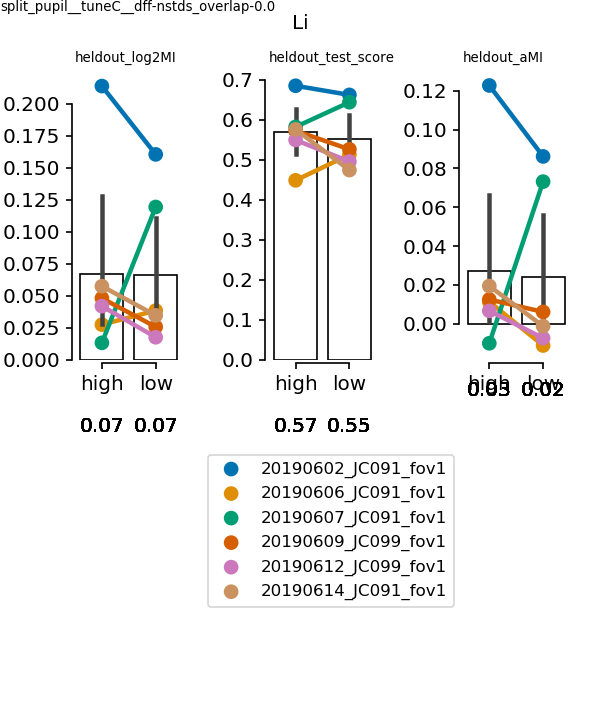

STATS - Li
heldout_log2MI--------------------
Paired t-test, t=-0.04 (p=0.97)
heldout_test_score--------------------
Paired t-test, t=-0.61 (p=0.57)
heldout_aMI--------------------
Paired t-test, t=-0.16 (p=0.88)
test_metrics_Li_color-datakeys__split_pupil__tuneC__dff-nstds_overlap-0.0


In [208]:
# exclude=['20190506_JC080_fov1', '20190512_JC083_fov1']
exclude = [] #copy.copy(li_exclude)
visual_area='Li'


#plotdf = df[~df['datakey'].isin(bad_dsets)].copy()

vdf = df[(df['visual_area']==visual_area) & (~df['datakey'].isin(exclude))]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)

    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))

    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3))
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5)
fig.suptitle(visual_area)

#
print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)

figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

In [104]:
from pipeline.python.eyetracker import dlc_utils as dlcutils

In [109]:
reload(dlcutils)

<module 'pipeline.python.eyetracker.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/eyetracker/dlc_utils.py'>

In [112]:

pupil_feature='pupil_fraction'
pupil_epoch = 'stimulus'
pupildata = dlcutils.get_aggregate_pupildfs(experiment=experiment, feature_name=pupil_feature,
                               trial_epoch=pupil_epoch, alignment_type='trial', 
                               in_rate=pupil_framerate, out_rate=pupil_framerate, 
                               iti_pre=iti_pre, iti_post=iti_post, stim_dur=stim_dur, create_new=True)


~~~~~ Aggregating pupil traces. ~~~~~~
Aggregated pupil traces. Missing 2 datasets.
20190422_JC076_fov1
20191008_JC091_fov1
~~~~~~~~~~~~ Aggregating pupil dataframes. ~~~~~~~~~~~
---> Saved aggr dataframes: /n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/metrics_blobs_pupil_fraction_stimulus_snapshot-391800.pkl


<IPython.core.display.Javascript object>


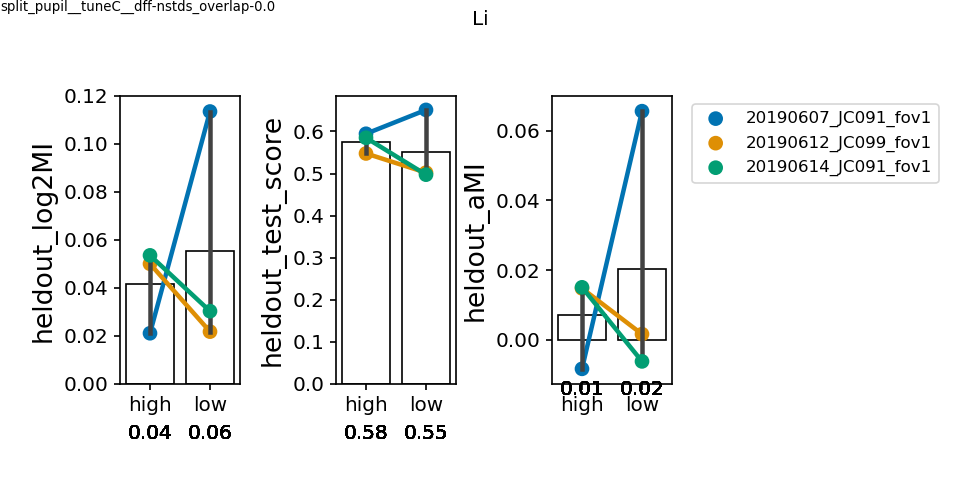

STATS - Li
heldout_log2MI--------------------
Paired t-test, t=0.35 (p=0.76)
heldout_test_score--------------------
Paired t-test, t=-0.59 (p=0.61)
heldout_aMI--------------------
Paired t-test, t=0.43 (p=0.71)


<IPython.core.display.Javascript object>


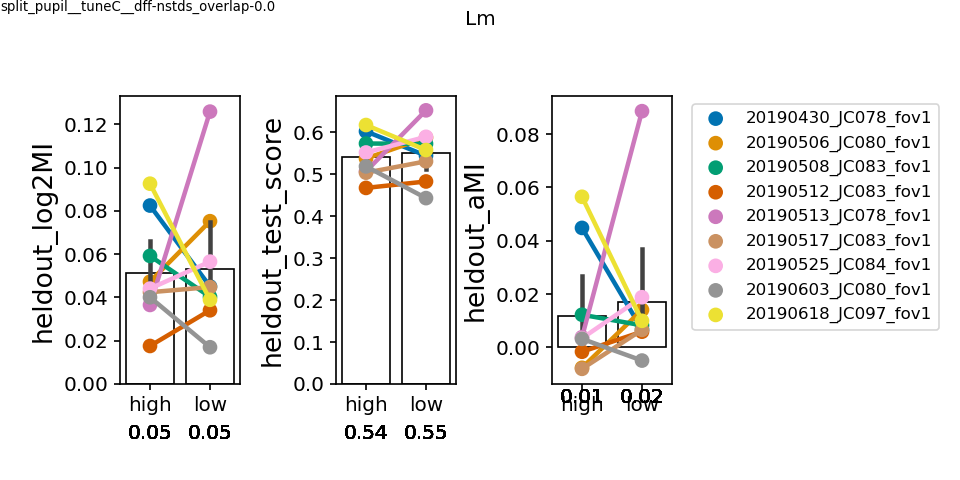

STATS - Lm
heldout_log2MI--------------------
Paired t-test, t=0.12 (p=0.91)
heldout_test_score--------------------
Paired t-test, t=0.39 (p=0.70)
heldout_aMI--------------------
Paired t-test, t=0.41 (p=0.69)


<IPython.core.display.Javascript object>


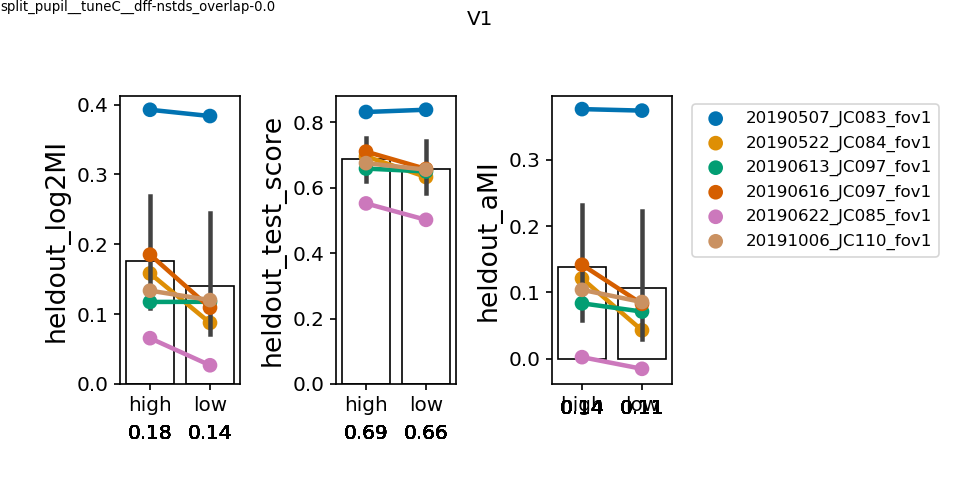

STATS - V1
heldout_log2MI--------------------
Paired t-test, t=-2.59 (p=0.05)
heldout_test_score--------------------
Paired t-test, t=-2.74 (p=0.04)
heldout_aMI--------------------
Paired t-test, t=-2.55 (p=0.05)


In [71]:

for visual_area, vdf in plotdf[~plotdf['datakey'].isin(exclude)].groupby(['visual_area']):

    xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
    metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

    fig, axn = pl.subplots(1, 3, figsize=(8,4), dpi=dpi)
    for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

        # Plot each fov
        sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                      palette='colorblind', s=10, alpha=0.5)
        
        sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                    edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
        
        xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))
        if ai<2:
            ax.legend_.remove()
        ax.set_xlabel('')

    ax.legend(bbox_to_anchor=(1.1, 1))
    pl.subplots_adjust(right=0.7, wspace=0.8, hspace=0.2, top=0.8, bottom=0.2)
    fig.suptitle(visual_area)
    
    #
    print("STATS - %s" % visual_area)
    metric = 'heldout_test_score'
    for metric in metrics:
        print('%s--------------------' % metric)
        a = xdf[(xdf['arousal']=='low')][metric]
        b = xdf[(xdf['arousal']=='high')][metric]
        tstat, pval = spstats.ttest_rel(a, b)
        print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

    putils.label_figure(fig, data_id)
    #C_str = 'C-%.2f' % C_value if C_value is not None else 'tuneC'
    #figname = '%s_%s_morph%iv%i_%s_%i-iters' % (face_feature, visual_area, m0, m100, C_str, n_iterations)
    #pl.savefig(os.path.join(dst_dir, '%s.svg' %figname))
    #print(dst_dir, figname)

# By FOV

# Filter bad stuff

In [46]:
#### Calculate overlap with stimulus
stim_overlaps = rfutils.calculate_overlaps(RFDATA, experiment=experiment)

In [47]:
remove_too_few = True
min_ncells=0
overlap_thr=0.5

####
globalcells, cell_counts = decutils.get_pooled_cells(stim_overlaps, remove_too_few=remove_too_few,
                                                     overlap_thr=overlap_thr, min_ncells=min_ncells)


             cell
visual_area      
Li            181
Lm            299
V1            766
('V1', 766)
('Lm', 299)
('Li', 181)


In [49]:
pass_overlaps = stim_overlaps[stim_overlaps['perc_overlap']>=overlap_thr].copy()
counts_by_dset = aggr.get_counts_by_datakey(pass_overlaps)
counts_by_dset.groupby(['visual_area']).sum()

n_cells  fovnum
visual_area                 
Li               181      10
Lm               299      13
V1               766      17

In [ ]:
dst_dir


<IPython.core.display.Javascript object>


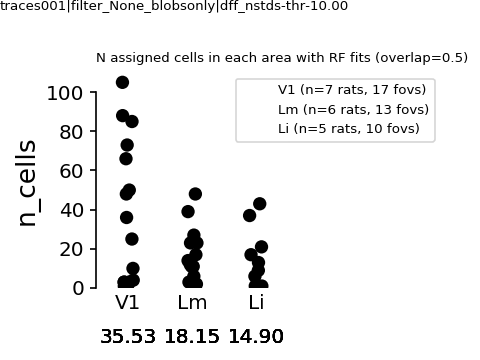

In [226]:
f, ax = pl.subplots(dpi=dpi, figsize=(4,3))
sns.stripplot(x='visual_area', y='n_cells', data=counts_by_dset, ax=ax,
             order=visual_areas, color='k', s=8, alpha=1)
sns.barplot(x='visual_area', y='n_cells', data=counts_by_dset, ax=ax,
             order=visual_areas, color='w', errcolor='w')
counts_by_dset.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))


ax.tick_params(which='both', axis='x', size=0)
ax.set_ylim([0, ax.get_ylim()[-1]])
sns.despine(bottom=True, trim=True, ax=ax)

ax.set_xlabel('')
pl.subplots_adjust(left=0.2, bottom=0.2, top=0.8)
ax.set_title("N assigned cells in each area with RF fits (overlap=%.1f)" % overlap_thr, loc='left', fontsize=8)
putils.label_figure(f, data_id)

leg = aggr.get_counts_for_legend(counts_by_dset, markersize=0, lw=0)
ax.legend(handles=leg, bbox_to_anchor=(1.8,1), fontsize=8)
pl.subplots_adjust(left=0.2, right=0.6, bottom=0.2)

figname = 'ncells_assigned_with_rfs__%s-%s__match-Li-distn' % (response_type, responsive_test)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


# Decode

In [17]:

test_split=0.2
cv_nfolds=5
C_value=None

class_a=0
class_b=106


#### Test boot iter for 1 cell

In [23]:
curr_ncells = 1
gdf = globalcells[globalcells['visual_area']=='V1'].copy() # globalcells for current visual_area


In [24]:
visual_area = 'V1'

datakey = '20190613_JC097_fov1'
sdf = SDF[datakey]
gdf = globalcells[globalcells['visual_area']==visual_area].copy() # globalcells for current visual_area

rid = 2
rid in gdf['dset_roi']


True

In [25]:
curr_data = NEURALDATA[visual_area][datakey][[rid, 'config']].copy()
print(curr_data.shape)
assert len(curr_data['config'].value_counts().unique())==1, "(%s) ERR: uneven trial counts by config" % datakey


(1500, 2)


In [26]:
n_iterations=100

i_=[]; s_=[];
for inum in np.arange(0, n_iterations):
    it_df, sh_df = decutils.do_fit_within_fov(inum, curr_data=curr_data, sdf=sdf, return_shuffle=True,
                                        C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds, 
                                        class_a=class_a, class_b=class_b)
    i_.append(it_df)
    s_.append(sh_df)
    
iterdf = pd.concat(i_, axis=0)
shufdf = pd.concat(s_, axis=0)
iterdf.mean()

<IPython.core.display.Javascript object>


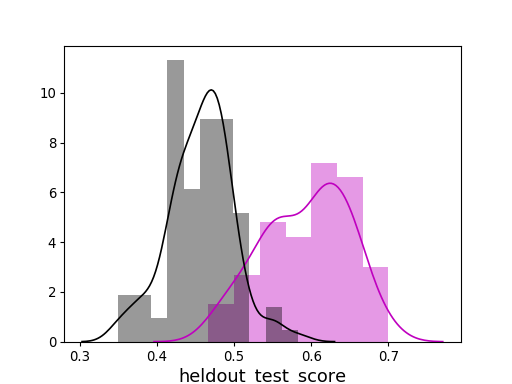

In [29]:
metric='heldout_test_score'
ci=0.95

f, ax = pl.subplots()
sns.distplot(iterdf[metric], color='m')
sns.distplot(shufdf[metric], color='k')

# ci_lo, ci_hi = putils.get_empirical_ci(iterdf[metric].values, ci=ci)
# ax.axvline(x=ci_lo, linestyle=':', c='k')
# ax.axvline(x=ci_hi, linestyle=':', c='k')

In [8]:
def load_cell_results_from_fov(animalid, session, fov, experiment, traceid='traces001',
                               C_value=None, response_type='dff', responsive_test='nstds',
                              rootdir='/n/coxfs01/2p-data'):
    '''
    From running batch, slurm/decode_by_ncells.py (Set analysis_type='single_cells'),
    load all the cells' results.
    '''
    roidf=None
    sub_dir = '%s-%s' % (response_type, responsive_test)
    #print(sub_dir)
    C_str = 'tuneC' if C_value is None else 'C-%.2f' % C_value
    cell_results = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                            'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                            'decoding', 'single_cells', sub_dir, '*%s*.pkl' % C_str))

    #print("... %i cell results" % len(cell_results))

    rlist=[]
    for c in cell_results:
        with open(c, 'rb') as f:
            r_ = pkl.load(f)
        means_ = r_.mean()
        non_num = [i for i in r_.columns if i not in means_.index]
        #metainfo = dict((k, r_[k].unique()[0]) for k in non_num)
        for k in non_num:
            means_[k] = r_[k].unique()[0]
        means_ = pd.to_numeric(r_.mean())

        rlist.append(means_)
        
    if len(rlist)>0:
        roidf = pd.concat(rlist, axis=1).T
    
    return roidf


In [ ]:
# INFO:  [7763640]: 20190507_JC083_fov1_V1_tuneC
# INFO:  [7763651]: 20190522_JC084_fov1_V1_tuneC   
        
# INFO:  [7763654]: 20190613_JC097_fov1_V1_tuneC 
# INFO:  [7763657]: 20190616_JC097_fov1_V1_tuneC 
# INFO:  [7763659]: 20190617_JC097_fov1_V1_tuneC
# INFO:  [7763661]: 20190622_JC085_fov1_V1_tuneC
# INFO:  [7763664]: 20191006_JC110_fov1_V1_tuneC

In [9]:
rootdir='/n/coxfs01/2p-data'
traceid='traces001'
experiment='blobs'
# -----------------------------------------------------
response_type='dff'
responsive_test='nstds'
# -----------------------------------------------------


In [ ]:
visual_area = 'Li'
animalid = 'JC091'
session = '20190614'
fovnum = 1
fov = 'FOV%i_zoom2p0x' % fovnum
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

# curr_ncells = globalcells[(globalcells['datakey']==datakey) & (globalcells['visual_area']==visual_area)].shape
roidf = load_cell_results_from_fov(animalid, session, fov, experiment, traceid=traceid,
                                   C_value=None, response_type=response_type, responsive_test=responsive_test,
                                   rootdir=rootdir)
curr_ncells = roidf.shape[0]
metainfo = {'datakey': datakey, 'visual_area': visual_area}
roidf = putils.add_meta_to_df(roidf, metainfo)


In [20]:
print(roidf.shape)
sub_dir = '%s-%s' % (response_type, responsive_test)
print(sub_dir)
C_str = 'tuneC' if C_value is None else 'C-%.2f' % C_value
cell_results = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                        'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                        'decoding', 'single_cells', sub_dir, '*%s*.pkl' % C_str))
print(len(cell_results))

(37, 14)
dff-nstds
37


<IPython.core.display.Javascript object>


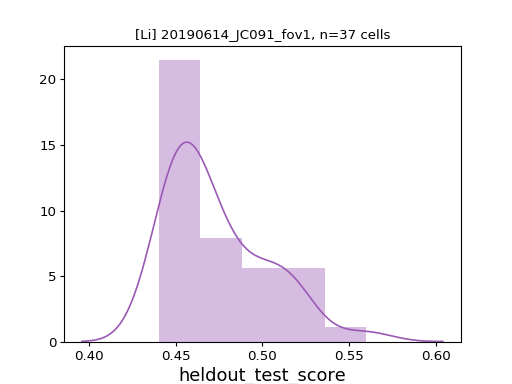

Text(0.5,1,u'[Li] 20190614_JC091_fov1, n=37 cells')

In [21]:
fig, ax = pl.subplots()
sns.distplot(roidf['heldout_test_score'], ax=ax)
ax.set_title("[%s] %s, n=%i cells" % (visual_area, datakey, curr_ncells))



In [10]:
r_list=[]
for (visual_area, animalid, session, fovnum, datakey), g in globalcells.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):
    roidf = load_cell_results_from_fov(animalid, session, 'FOV%i_zoom2p0x' % fovnum, experiment, traceid=traceid,rootdir=rootdir)
    if roidf is None:
        print("[%s] %s - No cells." % (visual_area, datakey))
        continue
    curr_ncells = roidf.shape[0]
    print("[%s] %s, n=%i cells" % (visual_area, datakey, curr_ncells))
    metainfo = {'datakey': datakey, 'visual_area': visual_area}
    roidf = putils.add_meta_to_df(roidf, metainfo)
    r_list.append(roidf)
singledf = pd.concat(r_list, axis=0)

NameError: name 'globalcells' is not defined

In [ ]:
INFO:  [7985264]: 20190430_JC078_fov1_Lm_tuneC
INFO:  [7985267]: 20190506_JC080_fov1_Lm_tuneC
INFO:  [7985271]: 20190513_JC078_fov1_Lm_tuneC
INFO:  [7985273]: 20190525_JC084_fov1_Lm_tuneC
INFO:  [7985276]: 20190618_JC097_fov1_Lm_tuneC
INFO:  [7985274]: 20190603_JC080_fov1_Lm_tuneC
        
INFO:  [7985265]: 20190504_JC078_fov1_Lm_tuneC
INFO:  [7985268]: 20190508_JC083_fov1_Lm_tuneC
INFO:  [7985269]: 20190509_JC078_fov1_Lm_tuneC
INFO:  [7985270]: 20190512_JC083_fov1_Lm_tuneC
INFO:  [7985272]: 20190517_JC083_fov1_Lm_tuneC
INFO:  [7985277]: 20190627_JC091_fov1_Lm_tune


In [47]:
min_ncells=60
curr_dkeys = [k for k, g in singledf.groupby(['datakey']) if len(g)<min_ncells]

<IPython.core.display.Javascript object>


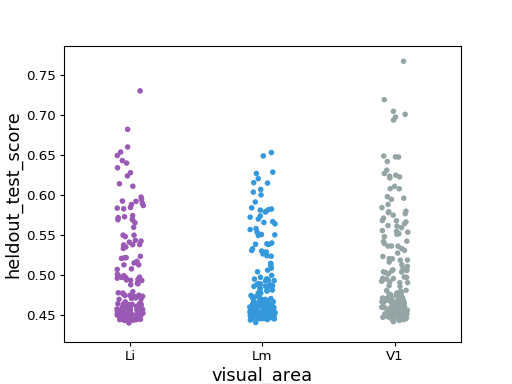

In [49]:
metric='heldout_test_score'

fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y=metric, data=singledf[singledf['datakey'].isin(curr_dkeys)], ax=ax)

In [28]:
singledf.groupby(['visual_area']).mean()

C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
visual_area                                                                
Li           8.390145  0.001162    0.011191     0.008852        0.016145   
Lm           7.421948  0.001123    0.008848     0.005680        0.012765   
V1           7.736929  0.001147    0.012561     0.010258        0.018121   

             heldout_test_score  n_cells    n_trials  score_time  test_score  \
visual_area                                                                    
Li                     0.498520      1.0  296.392405    0.000312    0.540805   
Lm                     0.488769      1.0  296.011236    0.000319    0.533930   
V1                     0.508667      1.0  303.130755    0.000292    0.546073   

             train_score        cell  
visual_area                           
Li              0.545417  152.436709  
Lm              0.538750  116.831461  
V1              0.550571  107.425414

<IPython.core.display.Javascript object>


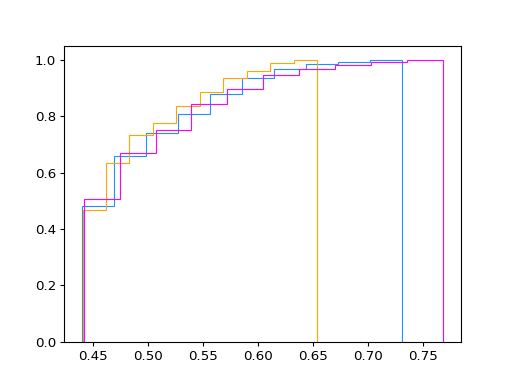

In [51]:
metric='heldout_test_score'
fig, ax = pl.subplots()
# for visual_area, vdf in singledf.groupby(['visual_area']):
#     sns.distplot(vdf[metric].values, color=area_colors[visual_area], ax=ax, kde=False, #bins=100,
#                 hist_kws={"histtype": "step", "linewidth": 3})

xdf = singledf[singledf['datakey'].isin(curr_dkeys)]
for visual_area, vdf in xdf.groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                                density=True, histtype='step', cumulative=True)
    
    
